# ASR Dataset Quality Evaluation

Manual quality check of 100 randomly sampled transcriptions from the [dataset](https://huggingface.co/datasets/islomov/news_youtube_uzbek_speech_dataset). 
Evaluated Word Error Rate (WER), Character Error Rate (CER), and foreign language contamination.

**Methodology:**
1. Randomly sampled 100 audio files from the dataset
2. Extracted audio from parquet files using sample IDs
3. Manually verified and corrected transcriptions using custom HTML checker tool
4. Computed WER/CER metrics and foreign words count

In [1]:
import gc  # Garbage collector
import glob
import os

import pandas as pd
from tqdm import tqdm  # Progress bar library

SEED = 137
DATASET_DIR = "../datasets/uzbekvoice_dataset/data"
SAMPLED_AUDIO_DIR = os.path.join(DATASET_DIR, "sampled_audio")
ALL_DATA_PATH = os.path.join(DATASET_DIR, "dataset.csv")

SAMPLED_DATA_PATH = os.path.join(DATASET_DIR, "sampled.csv")
PROCESSED_AUDIO_STATS_PATH = os.path.join(DATASET_DIR, "processed_audio_stats.csv")
TRANSCRIPTION_RESULTS_PATH = os.path.join(DATASET_DIR, "google_spt_transcriptions.csv")

SAMPLED_DATA2_PATH = os.path.join(DATASET_DIR, "sampled2.csv")
PROCESSED_AUDIO_STATS2_PATH = os.path.join(DATASET_DIR, "processed_audio_stats2.csv")
TRANSCRIPTION_RESULTS2_PATH = os.path.join(DATASET_DIR, "google_spt_transcriptions2.csv")

### Create csv file with all data and computed statistics

In [2]:
def compute_statistics(df: pd.DataFrame, ignore_sampling_rate=True) -> dict:
    """Extract statistics without keeping audio in memory"""
    stats = {
        "id": [],
        "path": [],
        "word_count": [],
        "char_count": [],
    }
    if not ignore_sampling_rate:
        stats["sampling_rate"] = []

    for i in range(len(df)):
        stats["id"].append(int(df.iloc[i]["id"]))
        # Note: df.iloc[i]["path"]["path"] is duplicated even though its is different audio files from different speakers
        stats["path"].append(str(df.iloc[i]["id"]) + ".wav")  # directly output file, input file is .mp3 extension

        text = df.iloc[i]["sentence"]

        stats["char_count"].append(len(text))
        stats["word_count"].append(len(text.split()))

    return stats


parquet_files = glob.glob(f"{DATASET_DIR}/*.parquet")
num_parquets = len(parquet_files)

if num_parquets == 0:
    raise FileNotFoundError(f"No parquet files found. Exiting...")

print(f"Found {num_parquets} parquet files. Started processing...\n")

all_data_df = pd.DataFrame()
for parquet_file_path in tqdm(parquet_files, desc="Processing files"):
    df_partial = pd.read_parquet(parquet_file_path)
    stats = compute_statistics(df_partial)
    df_partial.drop(columns=["path"], inplace=True)

    df_partial = df_partial.merge(
        pd.DataFrame(stats),
        how="left",
        left_on="id",
        right_on="id"
    )

    # Combine all data
    all_data_df: pd.DataFrame = pd.concat([all_data_df, df_partial], ignore_index=True)

    # Explicitly delete the dataframe with heavy audio bytes
    del df_partial
    gc.collect()

gc.collect()

all_data_df.set_index("id", inplace=True)
all_data_df.to_csv(ALL_DATA_PATH)

Found 33 parquet files. Started processing...



Processing files: 100%|██████████| 33/33 [01:22<00:00,  2.50s/it]


In [3]:
all_data_df.rename(columns={"client_id": "speaker_id", "downvotes_count": "down_votes", "upvotes_count": "up_votes",
                            "year_of_birth": "age"},
                   inplace=True)
all_data_df.drop(
    columns=["reported_reasons", "created_at", "skipped_clips", "original_sentence_id", "sentence_clips_count",
             "native_language"],
    inplace=True)

cols_in_order = ["path", "speaker_id", "accent_region", "up_votes", "down_votes", "reported_count", "age", "gender",
                 "duration", "word_count", "sentence"]
all_data_df = all_data_df[cols_in_order]
all_data_df.to_csv(ALL_DATA_PATH)

In [2]:
all_data_df = pd.read_csv(ALL_DATA_PATH, index_col="id")

print(all_data_df.info())
print(all_data_df.describe())
print("\nFirst few rows:")
all_data_df

<class 'pandas.core.frame.DataFrame'>
Index: 864778 entries, 210495 to 526178
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   path            864778 non-null  object 
 1   speaker_id      864778 non-null  object 
 2   accent_region   858950 non-null  object 
 3   up_votes        864778 non-null  int64  
 4   down_votes      864778 non-null  int64  
 5   reported_count  864778 non-null  int64  
 6   age             858950 non-null  object 
 7   gender          864778 non-null  object 
 8   duration        864778 non-null  float64
 9   word_count      864778 non-null  int64  
 10  sentence        864778 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 79.2+ MB
None
            up_votes     down_votes  reported_count       duration  \
count  864778.000000  864778.000000   864778.000000  864778.000000   
mean        0.695936       0.005198        0.008854       4.276783   
std         1

,path,speaker_id,accent_region,up_votes,down_votes,reported_count,age,gender,duration,word_count,sentence
id,,,,,,,,,,,
210495,210495.wav,6ff9168d-3398-412b-9510-7caa7628fae1,Farg'ona,0,0,0,18-24,female_feminine,1.908,3,Konsert yaxshi o‘tgan.
210496,210496.wav,e3bf850f-ae4b-424c-ab81-bddbab796b19,Namangan,0,0,0,19-29,female_feminine,3.204,4,Djigan Toshkentda konsert beradi.
210497,210497.wav,6ff9168d-3398-412b-9510-7caa7628fae1,Farg'ona,0,0,0,18-24,female_feminine,2.628,3,"Umuman olganda, qiziqmayman."
210498,210498.wav,348b2776-4432-44e7-868c-8fc11b674509,Toshkent viloyati,2,0,0,< 19,female_feminine,2.196,3,Lekin bolasi bo‘lmaydi.
210499,210499.wav,b2b2ee04-a86b-4ddc-8165-4be7a103fe2f,Jizzax,0,0,0,25-34,male_masculine,2.916,3,"Targ‘ibot qilishdi, tushuntirishdi."
...,...,...,...,...,...,...,...,...,...,...,...
526174,526174.wav,f3955702-ad1f-4896-b1f3-de8d2a5d381a,Jizzax,0,0,0,18-24,female_feminine,4.356,6,Toshkent shahrida alkogoldan zaharlanish holat...
526175,526175.wav,8a393ed4-c4c2-4f5f-8ea2-04401704ca56,Xorazm,0,0,0,18-24,female_feminine,2.808,6,"Agar u qo‘l qo‘ymasa, uni otishadi."
526176,526176.wav,d1f293f7-f89c-4455-91cc-140b0d4ac455,Samarqand,0,0,0,18-24,male_masculine,3.132,6,Voqea yuzasidan tergov ishlari olib borilmoqda.


In [3]:
# Fix age (year_of_birth) inconsistencies
def map_age_to_group(val):
    dataset_year = 2022

    # Convert to string to handle potential mixed types
    val_str = str(val).strip()

    # If it's already a range in your list, keep it
    if val_str in ["12-17", "< 19", "18-24", "19-29", "25-34", "30-39", "35-...", "40-49", "50-59", "60-69", "80-89",
                   "> 89"]:
        return val_str

    # Check if it's a Year of Birth (numeric and > 1900)
    try:
        num_val = float(val_str)
        if 1900 < num_val <= dataset_year:
            age = dataset_year - num_val

            # Mapping logic based on your specific groups
            if age < 12: return "Under 12"  # Optional: handling very young
            if 12 <= age <= 17: return "12-17"
            if 18 <= age <= 24: return "18-24"
            if 25 <= age <= 34: return "25-34"
            if 35 <= age <= 39: return "30-39"
            if 40 <= age <= 49: return "40-49"
            if 50 <= age <= 59: return "50-59"
            if 60 <= age <= 69: return "60-69"
            if 70 <= age <= 79: return "70-79"
            if 80 <= age <= 89: return "80-89"
            if age > 89: return "> 89"

            return "Other"

    except ValueError:
        return "Unknown"  # For non-numeric garbage data


# Apply the function to your column
all_data_df["age"] = all_data_df["age"].apply(map_age_to_group)
all_data_df["age"].value_counts()

age
18-24     656642
25-34      58271
19-29      45884
< 19       42458
12-17      27759
35-...     23286
30-39       3613
40-49        440
> 89         264
80-89        203
50-59        120
60-69         10
Name: count, dtype: int64

In [4]:
uz_translation = {"Ayol": "female_feminine", "Erkak": "male_masculine"}  # like in Common Voice
all_data_df.loc[:, "gender"] = all_data_df["gender"].replace(uz_translation)

all_data_df.fillna({"gender": "not_specified"}, inplace=True)

all_data_df = all_data_df[all_data_df["duration"] < 30]  # There was only 10 outlier recordings
all_data_df.to_csv(ALL_DATA_PATH)

### Dataset statistics plotted

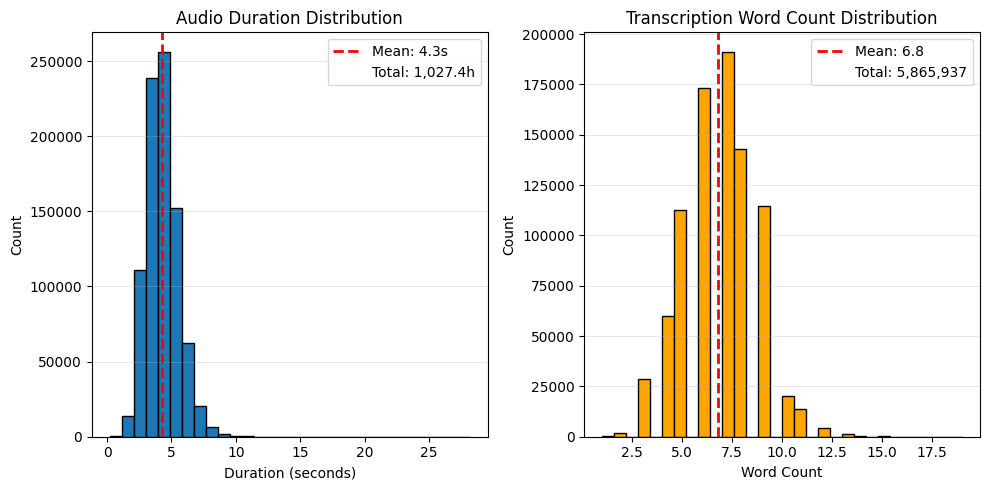

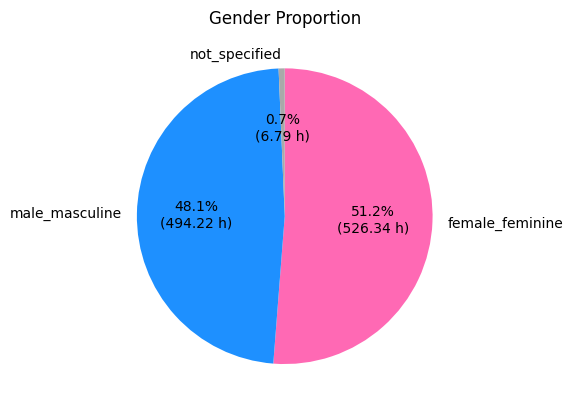

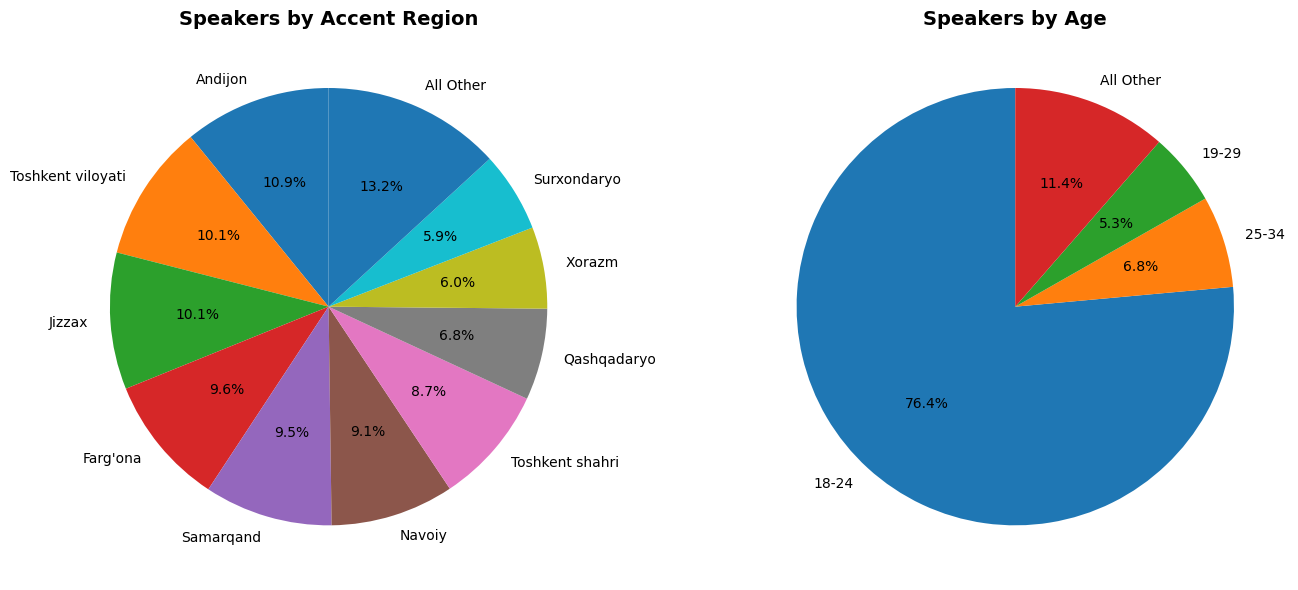


Total Unique Speakers: 5,576


speaker_id
4faeacd7-f209-47f1-80d7-47ff9969c7ce    33259
d1f293f7-f89c-4455-91cc-140b0d4ac455    32030
64f7ffe1-2c4e-459e-9155-5fc9a0bbe539    29510
231d3776-2dbe-4a42-a535-c67943427e3f    26706
8a393ed4-c4c2-4f5f-8ea2-04401704ca56    26621
                                        ...  
ec0b5010-1863-4873-acba-8b135da13f02        1
d9c9c4c5-5e54-4c7c-9203-3d26ef3c2147        1
92200a60-8711-41b4-81ae-561b40d60c34        1
f4de2a83-67a5-4886-9a29-aaf4e5465b0f        1
353dabcb-d42f-44ca-b423-2dea27b8d979        1
Name: count, Length: 5576, dtype: int64

In [5]:
from scripts.dataset_plotting import plot_distribution_graphs, plot_gender_pie_chart, \
    plot_accent_region_and_age_distribution

plot_distribution_graphs(all_data_df)
plot_gender_pie_chart(all_data_df)
plot_accent_region_and_age_distribution(all_data_df)

# Count recordings per speaker
speaker_counts = all_data_df["speaker_id"].value_counts()
print(f"\nTotal Unique Speakers: {len(speaker_counts):,.0f}")
speaker_counts

### Extract longer recordings

short_recordings: 
count                                    20000
unique                                    3957
top       c98a14fd-efaf-4219-b125-bf1a389bbf30
freq                                        19
Name: speaker_id, dtype: object

medium_recordings: 
count                                   133940
unique                                    3491
top       b35e4cb7-8c3b-4d96-be1e-d2eca1766857
freq                                      1100
Name: speaker_id, dtype: object

long_recordings: 
count                                     6246
unique                                     571
top       b2ea482e-0e57-428b-9a25-827582772fd7
freq                                       353
Name: speaker_id, dtype: object


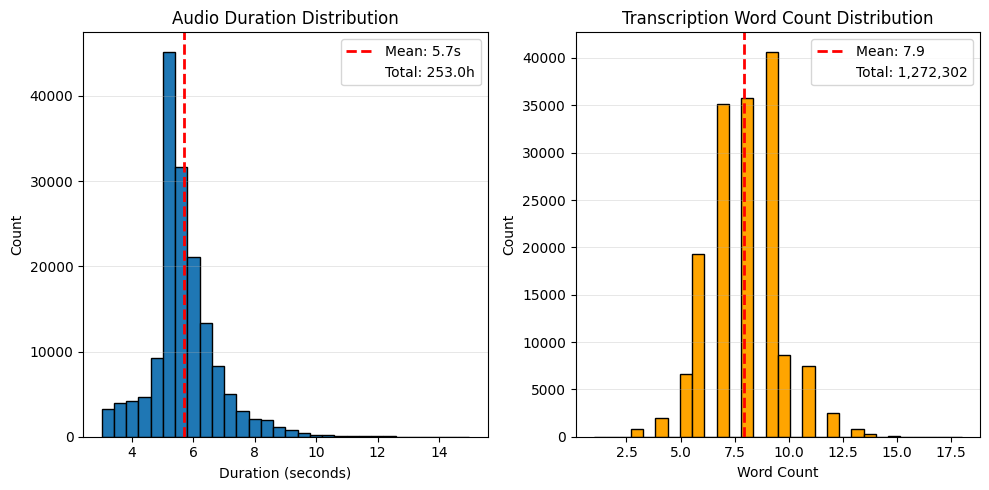

,speaker_id,path,accent_region,up_votes,down_votes,reported_count,age,gender,duration,word_count,sentence,net_votes
id,,,,,,,,,,,,
37,ad974593-4363-49c7-868b-24170166bdbf,37.wav,NaN,13,0,0,NaN,NaN,9.576,17,"Agar biz chiqarayotgan qaror noto‘g‘ri bo‘lsa,...",13
39,ad974593-4363-49c7-868b-24170166bdbf,39.wav,NaN,0,0,1,NaN,NaN,5.580,10,Diniy konfesiya rahbarlari Qurbon hayiti munos...,0
40,ad974593-4363-49c7-868b-24170166bdbf,40.wav,NaN,0,0,0,NaN,NaN,4.428,8,Tramp Kim Chen Inga Vyetnamda uchrashishni tak...,0
43,38486d7f-0cdc-43d8-8c04-bcdbf525bbd6,43.wav,NaN,2,0,0,NaN,NaN,9.468,14,"Uning tarkibidagi fitoestrogen, ayollar gormon...",2
44,38486d7f-0cdc-43d8-8c04-bcdbf525bbd6,44.wav,NaN,16,0,0,NaN,NaN,6.228,11,O‘zbekistondagi oliy va o‘rta maxsus islom bil...,16
...,...,...,...,...,...,...,...,...,...,...,...,...
864861,1684927e-c0ee-4208-a6ea-ddc556296815,864861.wav,Andijon,0,0,0,25-34,male_masculine,6.480,9,ba’zi kishilarga mazkur ochiq sudda ishtirok e...,0
864862,1684927e-c0ee-4208-a6ea-ddc556296815,864862.wav,Andijon,0,0,0,25-34,male_masculine,8.568,11,Sud ibodatxonani buzish haqida qaror chiqardi....,0
864863,1684927e-c0ee-4208-a6ea-ddc556296815,864863.wav,Andijon,0,0,0,25-34,male_masculine,7.920,13,"– Ochig‘ini aytsam, shu vaqtga qadar zamonaviy...",0


In [17]:
all_data_df = pd.read_csv(ALL_DATA_PATH, index_col="id")

# Sort by speaker_id for deterministic groupby order
all_data_df = all_data_df.sort_values("speaker_id")

short_audios = (all_data_df["duration"] >= 3) & (all_data_df["duration"] < 5)
medium_audios = (all_data_df["duration"] >= 5) & (all_data_df["duration"] < 8)
long_audios = (all_data_df["duration"] >= 8) & (all_data_df["duration"] <= 15)

short_samples = (
    all_data_df[short_audios]
    .groupby("speaker_id")
    .apply(lambda x: x.sample(min(len(x), 30), random_state=SEED),
           include_groups=False)  # Maximum up to 30 recordings per speaker
    .reset_index(level=0)
).sample(20_000, weights="duration", random_state=SEED)
print(f"short_recordings: \n{short_samples["speaker_id"].describe()}")

medium_samples = (
    all_data_df[medium_audios]
    .groupby("speaker_id")
    .apply(lambda x: x.sample(min(len(x), 1100), random_state=SEED),
           include_groups=False)  # Maximum up to 1100 recordings per speaker
    .reset_index(level=0)
)
print(f"\nmedium_recordings: \n{medium_samples["speaker_id"].describe()}")

long_samples = (
    all_data_df[long_audios]
    .groupby("speaker_id")
    .apply(lambda x: x.sample(min(len(x), 500), random_state=SEED),
           include_groups=False)  # Maximum up to 500 recordings per speaker
    .reset_index(level=0)
)
print(f"\nlong_recordings: \n{long_samples["speaker_id"].describe()}")

sampled_df = pd.concat([short_samples, medium_samples, long_samples]).sort_index()

# Remove recordings with net_votes <= -5 (up_votes - down_votes)
sampled_df.loc[:, "net_votes"] = sampled_df["up_votes"] - sampled_df["down_votes"]
majority_down_voted_mask = sampled_df["net_votes"] <= -5
sampled_df = sampled_df[~majority_down_voted_mask]

sampled_df.to_csv(SAMPLED_DATA_PATH)

plot_distribution_graphs(sampled_df)

sampled_df

### Extract audios from parquet files to manually check the quality of the overall dataset

In [3]:
import scripts.audio_preprocessing as ap

sampled_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")

# Extract sampled audios from parquets
sampled_ids = set(sampled_df.index.tolist())
print(f"Need to extract {len(sampled_ids)} audio files")

# Create directory for extracted audio
os.makedirs(SAMPLED_AUDIO_DIR, exist_ok=True)

parquet_files = glob.glob(f"{DATASET_DIR}/*.parquet")
num_parquets = len(parquet_files)

if num_parquets == 0:
    raise FileNotFoundError(f"No parquet files found. Exiting...")

print(f"Found {num_parquets} parquet files. Started processing...\n")

stats = []
found_count = 0
for parquet_file_path in tqdm(parquet_files, desc="Processing files"):
    if found_count >= len(sampled_ids):
        break

    df_partial = pd.read_parquet(parquet_file_path)

    # Filter to only rows we need
    matching_rows = df_partial[df_partial["id"].isin(sampled_ids)]

    if len(matching_rows) < 1:
        del df_partial
        continue

    # Extract and normalize audios from parquet files
    audio_stats_partial_df = pd.DataFrame()
    for _, row in matching_rows.iterrows():
        audio_bytes = row["path"]["bytes"]

        input_file_name = str(row["id"]) + ".mp3"
        output_file_name = str(row["id"]) + ".wav"
        output_path = os.path.join(SAMPLED_AUDIO_DIR, output_file_name)

        waveform, stat = ap.process_audio_bytes(
            input_file_name,
            audio_bytes,
            save_path=output_path,
            normalize=True,
            target_rms_db=-23.0,
            apply_highpass=True,
            highpass_cutoff=80.0,
            remove_silences=True,
            silence_threshold_db=-45.0,
            min_silence_duration=1.3
        )

        stats.append(stat)
        found_count += 1

    # Explicitly delete the dataframe with heavy audio bytes
    del df_partial
    gc.collect()

processed_audio_stats_df = pd.DataFrame(stats)
processed_audio_stats_df.to_csv(PROCESSED_AUDIO_STATS_PATH, index=False)

print(f"\nExtracted and normalized {found_count} audio files to {SAMPLED_AUDIO_DIR}")
processed_audio_stats_df

Need to extract 160118 audio files
Found 33 parquet files. Started processing...



Processing files: 100%|██████████| 33/33 [30:34<00:00, 55.59s/it]



Extracted and normalized 160118 audio files to ../datasets/uzbekvoice_dataset/data/sampled_audio


,input_audio_filename,original_rms_db,final_rms_db,original_duration,final_duration,reduced_duration,peak_amplitude,is_clipped
0,210508.mp3,-23.8663,-23.1517,3.348,3.348,0.0,0.6810,False
1,210517.mp3,-23.6393,-23.3166,3.348,3.348,0.0,0.7544,False
2,210526.mp3,-19.5121,-23.1433,3.888,3.888,0.0,0.5130,False
3,210541.mp3,-23.1994,-23.4505,3.744,3.744,0.0,0.7345,False
4,210568.mp3,-18.5818,-23.1065,3.564,3.564,0.0,0.4119,False
...,...,...,...,...,...,...,...,...
160113,525324.mp3,-13.3501,-23.0912,5.040,5.040,0.0,0.3424,False
160114,525328.mp3,-17.4020,-23.1183,5.580,5.580,0.0,0.4805,False
160115,525340.mp3,-15.2267,-23.1190,5.760,5.760,0.0,0.4044,False
160116,525442.mp3,-18.5884,-23.1401,5.688,5.688,0.0,0.4878,False


In [4]:
processed_audio_stats_df.describe()

/home/optimus/My Kingdom/Projects/UzbekASR/uzbek-automatic-speech-recognition/.venv/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/optimus/My Kingdom/Projects/UzbekASR/uzbek-automatic-speech-recognition/.venv/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,original_rms_db,final_rms_db,original_duration,final_duration,reduced_duration,peak_amplitude
count,160118.0000,160118.0000,160118.000000,160118.000000,160118.000000,160118.000000
mean,-inf,-inf,5.689164,5.659785,0.029379,0.485856
std,NaN,NaN,1.093014,1.076666,0.226486,0.106214
min,-inf,-inf,3.024000,0.500000,0.000000,0.000000
25%,-19.4580,-23.1743,5.148000,5.112000,0.000000,0.410200
50%,-17.7396,-23.1348,5.508000,5.508000,0.000000,0.471900
75%,-16.2320,-23.1072,6.156000,6.120000,0.000000,0.546600
max,-6.6981,-23.0358,14.976000,14.976000,8.434000,0.950000


In [5]:
import numpy as np

# Update all rows in the filename column
processed_audio_stats_df.loc[:, "input_audio_filename"] = (
    processed_audio_stats_df["input_audio_filename"].str.replace(r"\.mp3$", ".wav", regex=True)
)

# Remove silent recordings
is_inf = np.isinf(processed_audio_stats_df["original_rms_db"])
silent_recordings = (
    processed_audio_stats_df[is_inf]["input_audio_filename"].tolist()
)

processed_audio_stats_df = processed_audio_stats_df[~is_inf]
sampled_df = sampled_df[~sampled_df["path"].isin(silent_recordings)]
print(f"Identified and removed {len(silent_recordings)} silent recordings.")

processed_audio_stats_df.to_csv(PROCESSED_AUDIO_STATS_PATH)
sampled_df.to_csv(SAMPLED_DATA_PATH)

Identified and removed 5 silent recordings.


In [7]:
processed_audio_stats_df.describe()

,original_rms_db,final_rms_db,original_duration,final_duration,reduced_duration,peak_amplitude
count,160113.000000,160113.000000,160113.000000,160113.000000,160113.000000,160113.000000
mean,-17.998629,-23.150003,5.689182,5.659946,0.029236,0.485871
std,2.606981,0.075404,1.093008,1.076296,0.224939,0.106181
min,-40.482200,-27.484100,3.024000,1.430000,0.000000,0.154100
25%,-19.457800,-23.174300,5.148000,5.112000,0.000000,0.410200
50%,-17.739500,-23.134800,5.508000,5.508000,0.000000,0.471900
75%,-16.232000,-23.107200,6.156000,6.120000,0.000000,0.546600
max,-6.698100,-23.035800,14.976000,14.976000,8.434000,0.950000


In [8]:
sampled_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")
processed_audio_stats_df = pd.read_csv(PROCESSED_AUDIO_STATS_PATH)

old_total_duration = sampled_df["duration"].sum() / 3600
old_duration_mean = sampled_df["duration"].mean()

# --- Replace sampled_df.duration using processed_audio_stats_df.final_duration ---

# Merge final_duration into the sampled dataframe
sampled_df = sampled_df.merge(
    processed_audio_stats_df[["input_audio_filename", "final_duration"]],
    how="left",
    left_on="path",
    right_on="input_audio_filename"
)

# Replace duration only where we have final_duration
sampled_df["duration"] = (
    sampled_df["final_duration"].combine_first(sampled_df["duration"])
)

# Drop helper columns
sampled_df = sampled_df.drop(columns=["final_duration"])

# --- Remove suspiciously short and short recordings  ---

# Remove very short audios
mask_short_audio = (processed_audio_stats_df["final_duration"] < 3)
paths_to_remove = processed_audio_stats_df.loc[mask_short_audio, "input_audio_filename"].tolist()

total_reduced_duration = processed_audio_stats_df["reduced_duration"].sum() / 3600

# Remove these rows from processed stats
processed_audio_stats_df = processed_audio_stats_df[
    ~processed_audio_stats_df["input_audio_filename"].isin(paths_to_remove)
]

# Remove these recordings entirely
sampled_df = sampled_df[
    ~sampled_df["path"].isin(paths_to_remove)
]
print(f"{len(paths_to_remove)} recordings are removed from the sample")

# Updated totals
current_total_duration = processed_audio_stats_df["final_duration"].sum() / 3600
current_duration_mean = processed_audio_stats_df["final_duration"].mean()

# Save updated CSVs
processed_audio_stats_df.to_csv(PROCESSED_AUDIO_STATS_PATH)
sampled_df.to_csv(SAMPLED_DATA_PATH, index_label="id")

print(
    f"Before audio preprocessing: total duration - {old_total_duration:,.3f} h | mean {old_duration_mean:,.1f} s"
)
print(
    f"After audio preprocessing: total duration - {current_total_duration:,.3f} h "
    f"(reduced {total_reduced_duration * 60:.0f} min) | mean {current_duration_mean:,.1f} s"
)

sampled_df

44 recordings are removed from the sample
Before audio preprocessing: total duration - 253.031 h | mean 5.7 s
After audio preprocessing: total duration - 251.698 h (reduced 78 min) | mean 5.7 s


,speaker_id,path,accent_region,up_votes,down_votes,reported_count,age,gender,duration,word_count,sentence,net_votes,input_audio_filename
0,ad974593-4363-49c7-868b-24170166bdbf,37.wav,NaN,13,0,0,NaN,NaN,9.576,17,"Agar biz chiqarayotgan qaror noto‘g‘ri bo‘lsa,...",13,37.wav
1,ad974593-4363-49c7-868b-24170166bdbf,39.wav,NaN,0,0,1,NaN,NaN,5.580,10,Diniy konfesiya rahbarlari Qurbon hayiti munos...,0,39.wav
2,ad974593-4363-49c7-868b-24170166bdbf,40.wav,NaN,0,0,0,NaN,NaN,4.428,8,Tramp Kim Chen Inga Vyetnamda uchrashishni tak...,0,40.wav
3,38486d7f-0cdc-43d8-8c04-bcdbf525bbd6,43.wav,NaN,2,0,0,NaN,NaN,9.468,14,"Uning tarkibidagi fitoestrogen, ayollar gormon...",2,43.wav
4,38486d7f-0cdc-43d8-8c04-bcdbf525bbd6,44.wav,NaN,16,0,0,NaN,NaN,6.228,11,O‘zbekistondagi oliy va o‘rta maxsus islom bil...,16,44.wav
...,...,...,...,...,...,...,...,...,...,...,...,...,...
160108,1684927e-c0ee-4208-a6ea-ddc556296815,864861.wav,Andijon,0,0,0,25-34,male_masculine,6.480,9,ba’zi kishilarga mazkur ochiq sudda ishtirok e...,0,864861.wav
160109,1684927e-c0ee-4208-a6ea-ddc556296815,864862.wav,Andijon,0,0,0,25-34,male_masculine,8.568,11,Sud ibodatxonani buzish haqida qaror chiqardi....,0,864862.wav
160110,1684927e-c0ee-4208-a6ea-ddc556296815,864863.wav,Andijon,0,0,0,25-34,male_masculine,7.920,13,"– Ochig‘ini aytsam, shu vaqtga qadar zamonaviy...",0,864863.wav
160111,1684927e-c0ee-4208-a6ea-ddc556296815,864865.wav,Andijon,0,0,0,25-34,male_masculine,7.488,10,Olisda tahsil oladigan talabalar saylovda qays...,0,864865.wav


In [2]:
from sklearn.model_selection import train_test_split

sampled_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")
google_spt_check_1, google_spt_check_2 = train_test_split(
    sampled_df[sampled_df["net_votes"] < 5],
    test_size=0.5,
    random_state=SEED
)

google_spt_check_1.to_csv(os.path.join(DATASET_DIR, "google_spt_check_1.csv"))
google_spt_check_2.to_csv(os.path.join(DATASET_DIR, "google_spt_check_2.csv"))

In [2]:
# Before running set your own PROJECT_ID to .env file (e.g. GOOGLE_CLOUD_PROJECT="your id here")
from pathlib import Path
from scripts import google_transcribe

# Configuration
CHECKPOINT_INTERVAL = 1000  # Save every 1000 audio files
CHECKPOINT_PATH = "transcription_checkpoint.csv"

google_spt_check_2 = pd.read_csv(os.path.join(DATASET_DIR, "google_spt_check_2.csv"), index_col="id")

# Prepare audio paths
audio_paths = google_spt_check_2["path"].apply(
    lambda file_name: os.path.join(SAMPLED_AUDIO_DIR, file_name)
).tolist()

# Check for existing checkpoint
existing_results = []
processed_paths = set()

if os.path.exists(CHECKPOINT_PATH):
    print(f"Found existing checkpoint: {CHECKPOINT_PATH}")
    checkpoint_df = pd.read_csv(CHECKPOINT_PATH)
    existing_results = checkpoint_df.to_dict('records')
    processed_paths = set(checkpoint_df["path"].apply(lambda x: Path(x).name))
    print(f"Resuming from checkpoint with {len(existing_results)} already processed files")

    # Filter out already processed files
    audio_paths = [
        path for path in audio_paths
        if Path(path).name not in processed_paths
    ]
    print(f"Remaining files to process: {len(audio_paths)}")

# Process files in parallel using two regions
print(f"\nProcessing {len(audio_paths)} audio files using 2 regions (eu, us)...")
print("Starting parallel transcription with checkpoint saving...\n")


def save_checkpoint(results_list, is_final=False):
    """Save current results to checkpoint file"""
    df = pd.DataFrame(results_list)
    df.to_csv(CHECKPOINT_PATH, index_label="id")
    status = "FINAL" if is_final else "CHECKPOINT"
    print(f"\n[{status}] Saved {len(results_list)} results to: {CHECKPOINT_PATH}")


try:
    # Start with existing results
    all_results = existing_results.copy()

    # Process remaining files
    if audio_paths:
        results = google_transcribe.transcribe_batch_parallel(
            audio_paths=audio_paths,
            regions=["eu", "us"],
            max_workers=30,
            checkpoint_callback=lambda new_results: save_checkpoint(all_results + new_results),
            checkpoint_interval=CHECKPOINT_INTERVAL
        )
        all_results.extend(results)

    # Save final results
    save_checkpoint(all_results, is_final=True)

except KeyboardInterrupt:
    print("\n\n⚠️  Process interrupted by user!")
    print(f"Partial results saved to checkpoint: {CHECKPOINT_PATH}")
    print("You can resume by running this script again.")
    raise
except Exception as err:
    print(f"\n❌ Critical error during parallel processing: {type(err).__name__}: {err}")
    print(f"Partial results saved to checkpoint: {CHECKPOINT_PATH}")
    raise

# Process final results
predicted_transcriptions = []
failed_count = 0
success_count = 0

for result in all_results:
    transcription_entry = {
        "path": result["path"],
        "predicted_sentence": result["predicted_sentence"],
        "error_message": result["error_message"],
        "error_type": result["error_type"],
    }

    predicted_transcriptions.append(transcription_entry)

    if result["predicted_sentence"] is not None:
        success_count += 1
    else:
        failed_count += 1

# Save final results to the main output file
predicted_transcripts_df = pd.DataFrame(predicted_transcriptions)
predicted_transcripts_df.to_csv(TRANSCRIPTION_RESULTS_PATH, index_label="id")
print(f"\n✓ Saved final transcription results to: {TRANSCRIPTION_RESULTS_PATH}")

# Clean up checkpoint file
if os.path.exists(CHECKPOINT_PATH):
    os.remove(CHECKPOINT_PATH)
    print(f"✓ Removed checkpoint file: {CHECKPOINT_PATH}")

print(f"\n{'=' * 60}")
print(f"Transcription Complete!")
print(f"{'=' * 60}")
print(f"✓ Successfully transcribed: {success_count}")
print(f"✗ Failed: {failed_count}")
print(f"Success rate: {success_count / len(google_spt_check_2) * 100:.2f}%")

predicted_transcripts_df

Found existing checkpoint: transcription_checkpoint.csv
Resuming from checkpoint with 6100 already processed files
Remaining files to process: 69945

Processing 69945 audio files using 2 regions (eu, us)...
Starting parallel transcription with checkpoint saving...

Using 3 project(s) across 2 region(s)
Total combinations: 6


Transcribing:   1%|▏         | 1001/69945 [02:23<2:55:47,  6.54file/s]


[CHECKPOINT] Saved 7100 results to: transcription_checkpoint.csv


Transcribing:   3%|▎         | 2003/69945 [04:45<3:09:26,  5.98file/s]


[CHECKPOINT] Saved 8100 results to: transcription_checkpoint.csv


Transcribing:   4%|▍         | 3001/69945 [07:06<1:35:09, 11.72file/s]


[CHECKPOINT] Saved 9100 results to: transcription_checkpoint.csv


Transcribing:   6%|▌         | 4001/69945 [09:27<1:24:17, 13.04file/s]


[CHECKPOINT] Saved 10100 results to: transcription_checkpoint.csv


Transcribing:   7%|▋         | 5000/69945 [11:50<2:16:43,  7.92file/s]


[CHECKPOINT] Saved 11100 results to: transcription_checkpoint.csv


Transcribing:   9%|▊         | 6002/69945 [14:11<1:55:44,  9.21file/s]


[CHECKPOINT] Saved 12100 results to: transcription_checkpoint.csv


Transcribing:  10%|█         | 7000/69945 [16:34<1:52:44,  9.30file/s]


[CHECKPOINT] Saved 13100 results to: transcription_checkpoint.csv


Transcribing:  11%|█▏        | 8001/69945 [18:55<2:51:23,  6.02file/s]


[CHECKPOINT] Saved 14100 results to: transcription_checkpoint.csv


Transcribing:  13%|█▎        | 9001/69945 [21:17<3:36:34,  4.69file/s]


[CHECKPOINT] Saved 15100 results to: transcription_checkpoint.csv


Transcribing:  14%|█▍        | 10003/69945 [23:40<2:11:42,  7.59file/s]


[CHECKPOINT] Saved 16100 results to: transcription_checkpoint.csv


Transcribing:  16%|█▌        | 11001/69945 [26:03<1:37:04, 10.12file/s]


[CHECKPOINT] Saved 17100 results to: transcription_checkpoint.csv


Transcribing:  17%|█▋        | 12001/69945 [28:25<1:41:03,  9.56file/s]


[CHECKPOINT] Saved 18100 results to: transcription_checkpoint.csv


Transcribing:  19%|█▊        | 13001/69945 [30:45<2:19:49,  6.79file/s]


[CHECKPOINT] Saved 19100 results to: transcription_checkpoint.csv


Transcribing:  20%|██        | 14003/69945 [33:06<1:37:28,  9.56file/s]


[CHECKPOINT] Saved 20100 results to: transcription_checkpoint.csv


Transcribing:  21%|██▏       | 15003/69945 [35:27<1:54:53,  7.97file/s]


[CHECKPOINT] Saved 21100 results to: transcription_checkpoint.csv


Transcribing:  23%|██▎       | 16001/69945 [37:48<2:26:11,  6.15file/s]


[CHECKPOINT] Saved 22100 results to: transcription_checkpoint.csv


Transcribing:  24%|██▍       | 17002/69945 [40:08<1:33:57,  9.39file/s]


[CHECKPOINT] Saved 23100 results to: transcription_checkpoint.csv


Transcribing:  26%|██▌       | 18001/69945 [42:31<1:31:53,  9.42file/s]


[CHECKPOINT] Saved 24100 results to: transcription_checkpoint.csv


Transcribing:  27%|██▋       | 19001/69945 [44:52<2:17:45,  6.16file/s]


[CHECKPOINT] Saved 25100 results to: transcription_checkpoint.csv


Transcribing:  29%|██▊       | 19999/69945 [47:14<1:40:03,  8.32file/s]


[CHECKPOINT] Saved 26100 results to: transcription_checkpoint.csv


Transcribing:  30%|███       | 21001/69945 [49:37<2:51:21,  4.76file/s]


[CHECKPOINT] Saved 27100 results to: transcription_checkpoint.csv


Transcribing:  31%|███▏      | 22001/69945 [52:05<1:35:02,  8.41file/s] 


[CHECKPOINT] Saved 28100 results to: transcription_checkpoint.csv


Transcribing:  33%|███▎      | 23001/69945 [54:28<1:40:13,  7.81file/s]


[CHECKPOINT] Saved 29100 results to: transcription_checkpoint.csv


Transcribing:  34%|███▍      | 24000/69945 [56:48<1:18:10,  9.80file/s]


[CHECKPOINT] Saved 30100 results to: transcription_checkpoint.csv


Transcribing:  36%|███▌      | 25000/69945 [59:10<1:14:42, 10.03file/s]


[CHECKPOINT] Saved 31100 results to: transcription_checkpoint.csv


Transcribing:  37%|███▋      | 26001/69945 [1:01:37<1:40:13,  7.31file/s]


[CHECKPOINT] Saved 32100 results to: transcription_checkpoint.csv


Transcribing:  39%|███▊      | 27003/69945 [1:04:00<1:12:14,  9.91file/s]


[CHECKPOINT] Saved 33100 results to: transcription_checkpoint.csv


Transcribing:  40%|████      | 28001/69945 [1:06:22<1:55:33,  6.05file/s]


[CHECKPOINT] Saved 34100 results to: transcription_checkpoint.csv


Transcribing:  41%|████▏     | 29001/69945 [1:08:44<1:59:57,  5.69file/s]


[CHECKPOINT] Saved 35100 results to: transcription_checkpoint.csv


Transcribing:  43%|████▎     | 30000/69945 [1:11:05<1:23:45,  7.95file/s]


[CHECKPOINT] Saved 36100 results to: transcription_checkpoint.csv


Transcribing:  44%|████▍     | 31003/69945 [1:13:27<1:17:13,  8.40file/s]


[CHECKPOINT] Saved 37100 results to: transcription_checkpoint.csv


Transcribing:  46%|████▌     | 32000/69945 [1:15:48<1:43:47,  6.09file/s]


[CHECKPOINT] Saved 38100 results to: transcription_checkpoint.csv


Transcribing:  47%|████▋     | 33001/69945 [1:18:09<51:37, 11.93file/s]  


[CHECKPOINT] Saved 39100 results to: transcription_checkpoint.csv


Transcribing:  49%|████▊     | 34002/69945 [1:20:32<1:11:49,  8.34file/s]


[CHECKPOINT] Saved 40100 results to: transcription_checkpoint.csv


Transcribing:  50%|█████     | 35001/69945 [1:22:54<1:54:13,  5.10file/s]


[CHECKPOINT] Saved 41100 results to: transcription_checkpoint.csv


Transcribing:  51%|█████▏    | 36002/69945 [1:25:22<1:09:05,  8.19file/s]


[CHECKPOINT] Saved 42100 results to: transcription_checkpoint.csv


Transcribing:  53%|█████▎    | 37004/69945 [1:27:44<49:37, 11.06file/s]  


[CHECKPOINT] Saved 43100 results to: transcription_checkpoint.csv


Transcribing:  54%|█████▍    | 38001/69945 [1:30:20<1:06:29,  8.01file/s] 


[CHECKPOINT] Saved 44100 results to: transcription_checkpoint.csv


Transcribing:  56%|█████▌    | 39003/69945 [1:32:41<1:02:26,  8.26file/s]


[CHECKPOINT] Saved 45100 results to: transcription_checkpoint.csv


Transcribing:  57%|█████▋    | 39999/69945 [1:35:03<1:21:38,  6.11file/s]


[CHECKPOINT] Saved 46100 results to: transcription_checkpoint.csv


Transcribing:  59%|█████▊    | 41001/69945 [1:37:28<58:18,  8.27file/s]  


[CHECKPOINT] Saved 47100 results to: transcription_checkpoint.csv


Transcribing:  60%|██████    | 42001/69945 [1:39:50<1:04:10,  7.26file/s]


[CHECKPOINT] Saved 48100 results to: transcription_checkpoint.csv


Transcribing:  61%|██████▏   | 43004/69945 [1:42:12<53:48,  8.34file/s]  


[CHECKPOINT] Saved 49100 results to: transcription_checkpoint.csv


Transcribing:  63%|██████▎   | 44000/69945 [1:44:31<43:26,  9.95file/s]  


[CHECKPOINT] Saved 50100 results to: transcription_checkpoint.csv


Transcribing:  64%|██████▍   | 45007/69945 [1:46:53<37:13, 11.17file/s]  


[CHECKPOINT] Saved 51100 results to: transcription_checkpoint.csv


Transcribing:  66%|██████▌   | 46002/69945 [1:49:14<1:12:17,  5.52file/s]


[CHECKPOINT] Saved 52100 results to: transcription_checkpoint.csv


Transcribing:  67%|██████▋   | 47001/69945 [1:51:36<43:39,  8.76file/s]  


[CHECKPOINT] Saved 53100 results to: transcription_checkpoint.csv


Transcribing:  69%|██████▊   | 48006/69945 [1:53:59<37:11,  9.83file/s]  


[CHECKPOINT] Saved 54100 results to: transcription_checkpoint.csv


Transcribing:  70%|███████   | 49001/69945 [1:56:25<58:10,  6.00file/s]  


[CHECKPOINT] Saved 55100 results to: transcription_checkpoint.csv


Transcribing:  71%|███████▏  | 50001/69945 [1:58:46<36:50,  9.02file/s]  


[CHECKPOINT] Saved 56100 results to: transcription_checkpoint.csv


Transcribing:  73%|███████▎  | 51001/69945 [2:01:08<59:10,  5.34file/s]  


[CHECKPOINT] Saved 57100 results to: transcription_checkpoint.csv


Transcribing:  74%|███████▍  | 52003/69945 [2:03:31<36:40,  8.15file/s]  


[CHECKPOINT] Saved 58100 results to: transcription_checkpoint.csv


Transcribing:  76%|███████▌  | 53001/69945 [2:05:53<37:20,  7.56file/s]  


[CHECKPOINT] Saved 59100 results to: transcription_checkpoint.csv


Transcribing:  77%|███████▋  | 54004/69945 [2:08:15<30:10,  8.80file/s]  


[CHECKPOINT] Saved 60100 results to: transcription_checkpoint.csv


Transcribing:  79%|███████▊  | 55003/69945 [2:10:38<29:12,  8.53file/s]  


[CHECKPOINT] Saved 61100 results to: transcription_checkpoint.csv


Transcribing:  80%|████████  | 56003/69945 [2:13:01<30:17,  7.67file/s]  


[CHECKPOINT] Saved 62100 results to: transcription_checkpoint.csv


Transcribing:  81%|████████▏ | 57002/69945 [2:15:22<31:00,  6.96file/s]


[CHECKPOINT] Saved 63100 results to: transcription_checkpoint.csv


Transcribing:  83%|████████▎ | 58005/69945 [2:17:43<21:17,  9.35file/s]  


[CHECKPOINT] Saved 64100 results to: transcription_checkpoint.csv


Transcribing:  84%|████████▍ | 59003/69945 [2:20:05<21:21,  8.54file/s]


[CHECKPOINT] Saved 65100 results to: transcription_checkpoint.csv


Transcribing:  86%|████████▌ | 60002/69945 [2:22:28<20:01,  8.27file/s]


[CHECKPOINT] Saved 66100 results to: transcription_checkpoint.csv


Transcribing:  87%|████████▋ | 61003/69945 [2:24:51<21:04,  7.07file/s]


[CHECKPOINT] Saved 67100 results to: transcription_checkpoint.csv


Transcribing:  89%|████████▊ | 62002/69945 [2:27:11<17:52,  7.41file/s]


[CHECKPOINT] Saved 68100 results to: transcription_checkpoint.csv


Transcribing:  90%|█████████ | 63000/69945 [2:29:37<10:01, 11.55file/s]


[CHECKPOINT] Saved 69100 results to: transcription_checkpoint.csv


Transcribing:  92%|█████████▏| 64005/69945 [2:31:59<11:40,  8.48file/s]


[CHECKPOINT] Saved 70100 results to: transcription_checkpoint.csv


Transcribing:  93%|█████████▎| 65001/69945 [2:34:25<12:26,  6.62file/s]  


[CHECKPOINT] Saved 71100 results to: transcription_checkpoint.csv


Transcribing:  94%|█████████▍| 66001/69945 [2:36:47<11:13,  5.85file/s]


[CHECKPOINT] Saved 72100 results to: transcription_checkpoint.csv


Transcribing:  96%|█████████▌| 67002/69945 [2:39:09<06:02,  8.11file/s]


[CHECKPOINT] Saved 73100 results to: transcription_checkpoint.csv


Transcribing:  97%|█████████▋| 68001/69945 [2:41:30<05:46,  5.61file/s]


[CHECKPOINT] Saved 74100 results to: transcription_checkpoint.csv


Transcribing:  99%|█████████▊| 69001/69945 [2:43:51<02:08,  7.33file/s]


[CHECKPOINT] Saved 75100 results to: transcription_checkpoint.csv


Transcribing: 100%|██████████| 69945/69945 [2:46:02<00:00,  7.02file/s]



[CHECKPOINT] Saved 76045 results to: transcription_checkpoint.csv

[FINAL] Saved 76045 results to: transcription_checkpoint.csv

✓ Saved final transcription results to: ../datasets/uzbekvoice_dataset/data/google_spt_transcriptions.csv
✓ Removed checkpoint file: transcription_checkpoint.csv

Transcription Complete!
✓ Successfully transcribed: 76044
✗ Failed: 1
Success rate: 100.00%


,path,predicted_sentence,error_message,error_type
0,../datasets/uzbekvoice_dataset/data/sampled_au...,NaN,403 Permission 'speech.recognizers.recognize' ...,PermissionDenied
1,../datasets/uzbekvoice_dataset/data/sampled_au...,NaN,403 Permission 'speech.recognizers.recognize' ...,PermissionDenied
2,../datasets/uzbekvoice_dataset/data/sampled_au...,NaN,403 Permission 'speech.recognizers.recognize' ...,PermissionDenied
3,../datasets/uzbekvoice_dataset/data/sampled_au...,NaN,403 Permission 'speech.recognizers.recognize' ...,PermissionDenied
4,../datasets/uzbekvoice_dataset/data/sampled_au...,NaN,403 Permission 'speech.recognizers.recognize' ...,PermissionDenied
...,...,...,...,...
76040,../datasets/uzbekvoice_dataset/data/sampled_au...,Keyingi yillarda fermerlar bug'doyning faqat z...,None,None
76041,../datasets/uzbekvoice_dataset/data/sampled_au...,Fotogalereya: Avstraliyada davom etayotgan o'r...,None,None
76042,../datasets/uzbekvoice_dataset/data/sampled_au...,Real Madridning yakuniga yetgan mavsumdagi eng...,None,None
76043,../datasets/uzbekvoice_dataset/data/sampled_au...,Parij ma'muriyati shaharliklarni bir haftaga a...,None,None


In [5]:


google_spt_checked_1 = pd.read_csv(os.path.join(DATASET_DIR, "google_spt_transcriptions1.csv"), index_col="id")
google_spt_checked_2 = pd.read_csv(os.path.join(DATASET_DIR, "google_spt_transcriptions2.csv"), index_col="id")
# google_spt_checked_3 is just 2nd part that has errors
google_spt_checked_3 = pd.read_csv(os.path.join(DATASET_DIR, "google_spt_transcriptions3.csv"), index_col="id")

google_spt_checked_1["path"] = google_spt_checked_1["path"].apply(lambda x: Path(x).name)
google_spt_checked_2["path"] = google_spt_checked_2["path"].apply(lambda x: Path(x).name)
google_spt_checked_3["path"] = google_spt_checked_3["path"].apply(lambda x: Path(x).name)

# Check if rows with errors in checked_2 match paths in checked_3
errors_in_2 = google_spt_checked_2[~google_spt_checked_2["error_message"].isna()]
matches = errors_in_2["path"].isin(google_spt_checked_3["path"])

# Update predicted_sentence for matched rows
for path in errors_in_2[matches]["path"]:
    # Get the predicted_sentence from checked_3
    pred_sentence = google_spt_checked_3[google_spt_checked_3["path"] == path]["predicted_sentence"].values[0]
    # Update in checked_2
    google_spt_checked_2.loc[google_spt_checked_2["path"] == path, "predicted_sentence"] = pred_sentence

google_spt_checked = pd.concat([google_spt_checked_1, google_spt_checked_2], ignore_index=True).sort_values("path")
google_spt_checked.to_csv(TRANSCRIPTION_RESULTS_PATH, index_label="id")
google_spt_checked

,path,predicted_sentence,error_message,error_type
60190,100004.wav,Hozirda qo'shimcha surishtiruv ishlari davom e...,NaN,NaN
116274,100005.wav,Aksariyat foydalanuvchilar esa ushbu tashabbus...,NaN,NaN
104647,100023.wav,Ularning orasida bir bola ham bor.,NaN,NaN
36636,100024.wav,O'z qozig'imiz atrofida aylanishimiz shu menim...,NaN,NaN
58402,100030.wav,"Avvalo, podstansiyalar yetarlicha himoyaga ega...",NaN,NaN
...,...,...,...,...
67083,99993.wav,Zangiota majmuasidagi qurilish va obodonlashti...,NaN,NaN
13948,99994.wav,Amerikalik olimlar yerga o'xshash sayyorani an...,NaN,NaN
140650,99995.wav,O'lim holati ayol kishida qayd etilgan.,NaN,NaN
66942,99996.wav,Bo'sh koyka o'rinlar qolmadi. Habibulla Oqilov,NaN,NaN


In [3]:
sampled_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")
predicted_transcripts_df = pd.read_csv(TRANSCRIPTION_RESULTS_PATH, index_col="id")

print(predicted_transcripts_df.info())

# Merge transcription results with original data
sampled_df = sampled_df.merge(
    predicted_transcripts_df,
    left_on="path",
    right_on="path",
    how="left"
)

sampled_df.drop(columns=["error_message", "error_type", "input_audio_filename", "char_count"], inplace=True,
                errors="ignore")
sampled_df.rename(columns={"sentence": "text_original", "predicted_sentence": "text_spt"}, inplace=True)

# Reorder columns
cols = list(sampled_df.columns)
cols.remove("net_votes")
cols.remove("text_original")
cols.insert(5, "net_votes")
cols.insert(-1, "text_original")
sampled_df = sampled_df[cols]

sampled_df

<class 'pandas.core.frame.DataFrame'>
Index: 152089 entries, 60190 to 143093
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   path                152089 non-null  object
 1   predicted_sentence  151843 non-null  object
 2   error_message       1101 non-null    object
 3   error_type          1101 non-null    object
dtypes: object(4)
memory usage: 5.8+ MB
None


,speaker_id,path,accent_region,up_votes,down_votes,net_votes,reported_count,age,gender,duration,word_count,text_original,text_spt
0,ad974593-4363-49c7-868b-24170166bdbf,37.wav,NaN,13,0,13,0,NaN,NaN,9.576,17,"Agar biz chiqarayotgan qaror noto‘g‘ri bo‘lsa,...",NaN
1,ad974593-4363-49c7-868b-24170166bdbf,39.wav,NaN,0,0,0,1,NaN,NaN,5.580,10,Diniy konfesiya rahbarlari Qurbon hayiti munos...,Diniy konferensiya rahbarlari Qurbon hayiti mu...
2,ad974593-4363-49c7-868b-24170166bdbf,40.wav,NaN,0,0,0,0,NaN,NaN,4.428,8,Tramp Kim Chen Inga Vyetnamda uchrashishni tak...,Trump Kim Jong Unga Vyetnam uchrashishni takli...
3,38486d7f-0cdc-43d8-8c04-bcdbf525bbd6,43.wav,NaN,2,0,2,0,NaN,NaN,9.468,14,"Uning tarkibidagi fitoestrogen, ayollar gormon...",Uning tarkibidagi fitoestrogen ayollar gormoni...
4,38486d7f-0cdc-43d8-8c04-bcdbf525bbd6,44.wav,NaN,16,0,16,0,NaN,NaN,6.228,11,O‘zbekistondagi oliy va o‘rta maxsus islom bil...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
160064,1684927e-c0ee-4208-a6ea-ddc556296815,864861.wav,Andijon,0,0,0,0,25-34,male_masculine,6.480,9,ba’zi kishilarga mazkur ochiq sudda ishtirok e...,Ba'zi kishilarga mazkur ochiq sudda ishtirok e...
160065,1684927e-c0ee-4208-a6ea-ddc556296815,864862.wav,Andijon,0,0,0,0,25-34,male_masculine,8.568,11,Sud ibodatxonani buzish haqida qaror chiqardi....,Sud ibodatxonani buzish haqida qaror chiqardi....
160066,1684927e-c0ee-4208-a6ea-ddc556296815,864863.wav,Andijon,0,0,0,0,25-34,male_masculine,7.920,13,"– Ochig‘ini aytsam, shu vaqtga qadar zamonaviy...","Ochig'ini aytsam, shu vaqtga qadar zamonaviy b..."
160067,1684927e-c0ee-4208-a6ea-ddc556296815,864865.wav,Andijon,0,0,0,0,25-34,male_masculine,7.488,10,Olisda tahsil oladigan talabalar saylovda qays...,Olisda tahsil oladigan talabalar saylovda qays...


In [4]:
# Check if it contains number in digits and number in words (136 000 - bir yuz o'ttiz olti ming)
pattern = r"^(\d+(?: \d{3})*) - [\w| |']+$"
mask = sampled_df["text_original"].str.contains(pattern, regex=True, na=False)

print(f"Affected number of rows: {len(sampled_df[mask])}")
print("\nRandom 5 rows that matches the pattern:")
matched_5_rows = sampled_df[mask][["path", "text_original", "text_spt"]].sample(5)

sampled_df.loc[mask, "text_original"] = sampled_df.loc[mask, "text_original"].str.extract(pattern, expand=False)
matched_5_rows

Affected number of rows: 724

Random 5 rows that matches the pattern:


/tmp/ipykernel_30036/1456049374.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = sampled_df["text_original"].str.contains(pattern, regex=True, na=False)


,path,text_original,text_spt
157649,856990.wav,448 076 - to'rt yuz qirq sakkiz ming yetmish olti,448076
158286,859174.wav,623 261 - olti yuz yigirma uch ming ikki yuz o...,623261
158555,860470.wav,277 318 - ikki yuz yetmish yetti ming uch yuz ...,277318
158241,858925.wav,459 778 - to'rt yuz ellik to'qqiz ming yetti y...,459778
158843,861543.wav,620 559 - olti yuz yigirma ming besh yuz ellik...,620 559


In [5]:


# Apply similarity metrics to each row
metrics = sampled_df.apply(
    lambda row: similarity_metrics.calculate(
        reference=row["text_original"],
        hypothesis=row["text_spt"],  # Google SPT generated text
    ),
    axis=1
)

# Convert list of dicts → DataFrame
metrics_df = pd.DataFrame(metrics.tolist())

# Merge metric columns back into main DataFrame and save
sampled_df: pd.DataFrame = pd.concat([sampled_df, metrics_df], axis=1)

sampled_df.sort_values("wer", ascending=False)

While converting '1 000 793 000 677 000' to number, IndexError error occurred: list index out of range
While converting '6 000 000 127 318' to number, IndexError error occurred: list index out of range


,speaker_id,path,accent_region,up_votes,down_votes,net_votes,reported_count,age,gender,duration,word_count,text_original,text_spt,ref_normalized,hyp_normalized,wer,cer,sequence_similarity,ref_word_count,hyp_word_count
85636,6db67690-f32d-4a63-bca1-b143c55e6fc6,445668.wav,Toshkent shahri,0,0,0,0,18-24,female_feminine,7.992,9,Yancheng Dafeng Dream Maze labirinti Xitoyning...,Yancheng da joylashgan Yancheng da joylashgan ...,yancheng dafeng dream maze labirinti xitoyning...,yancheng da joylashgan yancheng da joylashgan ...,684.4444,589.8000,0.0005,9,6162
139321,56ac8e86-b8c9-4879-a342-0eeb94f686fc,768177.wav,Qashqadaryo,0,0,0,0,< 19,female_feminine,8.326,11,Farmon bilan yuridik taʼlim va fanni yana-da r...,Farom bilan yurgan edim va va va va va va va v...,farmon bilan yuridik ta'lim va fanni yana-da r...,farom bilan yurgan edim va va va va va va va v...,583.8182,200.5000,0.0018,11,6424
143485,56ac8e86-b8c9-4879-a342-0eeb94f686fc,789197.wav,Qashqadaryo,0,0,0,0,< 19,female_feminine,5.112,7,nimaga instagramda shu mashhur insonni hayotin...,Instagramda shu mashhur insonni hayotini le le...,nimaga instagramda shu mashhur insonni hayotin...,instagramda shu mashhur insonni hayotini le le...,472.0000,157.3175,0.0086,7,3308
119884,fdef1682-7435-4a3c-9338-25b7bff2c822,664654.wav,Samarqand,0,0,0,0,18-24,female_feminine,5.616,8,"Pudradan foydalanishda rangsiz, uqalanib ketma...","pudradan foydalanishda rangsiz, uqalanishda ra...",pudradan foydalanishda rangsiz uqalanib ketmay...,pudradan foydalanishda rangsiz uqalanishda ran...,325.2500,324.7625,0.0029,8,2605
21454,b2ea482e-0e57-428b-9a25-827582772fd7,131389.wav,Sirdaryo,0,4,-4,0,25-34,male_masculine,14.148,7,Buning uchun pushti suyuqlik mitselyar suv ish...,"Buning uchun pochti suyuqlik, biz, biz, biz, b...",buning uchun pushti suyuqlik mitselyar suv ish...,buning uchun pochti suyuqlik biz biz biz biz b...,184.1429,95.3148,0.0103,7,1292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97915,f667bd0e-3682-48ad-a7ec-33babbc46a92,476277.wav,Buxoro,2,0,2,0,18-24,female_feminine,5.256,9,Qrimda Robinson vertolyotining qulashi oqibati...,Qrimda Robinson vertolyotining qulashi oqibati...,qrimda robinson vertolyotining qulashi oqibati...,qrimda robinson vertolyotining qulashi oqibati...,0.0000,0.0000,1.0000,9,9
57682,ef6c61a2-6841-4065-a513-67bd64524d5c,353534.wav,Namangan,0,0,0,0,19-29,male_masculine,7.056,7,"Ortimda butun mamlakat turganini, meni qo‘llab...","Ortimda butun mamlakat turganini, meni qo'llab...",ortimda butun mamlakat turganini meni qo'llab-...,ortimda butun mamlakat turganini meni qo'llab-...,0.0000,0.0000,1.0000,7,7
57681,466e75d9-8241-4108-9efb-3ce309d3287e,353526.wav,Xorazm,0,0,0,0,18-24,female_feminine,5.184,8,"Onasi, akasi ishlaydi, o‘zi ham ustachilik bil...","Onasi, akasi ishlaydi. O'zi ham ustachilik bil...",onasi akasi ishlaydi o'zi ham ustachilik bilan...,onasi akasi ishlaydi o'zi ham ustachilik bilan...,0.0000,0.0000,1.0000,8,8
57680,8a393ed4-c4c2-4f5f-8ea2-04401704ca56,353525.wav,Xorazm,0,0,0,0,18-24,female_feminine,5.184,8,Doimiy reyslarning taqiqlanishi haqida hujjatd...,Doimiy reyslarning taqiqlanishi haqida hujjatd...,doimiy reyslarning taqiqlanishi haqida hujjatd...,doimiy reyslarning taqiqlanishi haqida hujjatd...,0.0000,0.0000,1.0000,8,8


In [6]:
duration_with_high_wer = sampled_df[sampled_df["wer"] >= 1.0]["duration"].sum() / 3600
estimated_original_wer = sampled_df[sampled_df["wer"] < 1.0]["wer"].mean()
print(
    f"Estimated rough WER: {estimated_original_wer * 100:.2f}% (after removing WER >= 100%, amounting {duration_with_high_wer:.2f} hours)")

Estimated rough WER: 8.72% (after removing WER >= 100%, amounting 13.17 hours)


In [27]:
from scripts.uzbek_text_normalizer import normalize_text

sampled_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")
# Add back of net_votes >= 5 as text_spt generated
mask = sampled_df["net_votes"] >= 5
sampled_df.loc[mask, "text_spt"] = sampled_df.loc[mask, "text_original"]
sampled_df.loc[mask, "hyp_normalized"] = sampled_df.loc[mask, "text_spt"].apply(
    lambda text: normalize_text(
        text,
        should_normalize_numbers_to_words=True,
        should_remove_punctuations=True,
        should_lowercase_text=True,
        should_remove_ellipsis=True,
    ))
sampled_df.loc[mask, "wer"] = 0.0
sampled_df.loc[mask, "cer"] = 0.0
sampled_df.loc[mask, "sequence_similarity"] = 1.0
sampled_df.loc[mask, "hyp_word_count"] = sampled_df.loc[mask, "ref_word_count"]

sampled_df.info()
sampled_df.to_csv(os.path.join(DATASET_DIR, "sampled_before_wer_filtering.csv"), index_label="id")

<class 'pandas.core.frame.DataFrame'>
Index: 98673 entries, 0 to 160068
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   speaker_id           98673 non-null  object 
 1   path                 98673 non-null  object 
 2   type                 98673 non-null  object 
 3   accent_region        97646 non-null  object 
 4   up_votes             98673 non-null  int64  
 5   down_votes           98673 non-null  int64  
 6   net_votes            98673 non-null  int64  
 7   reported_count       98673 non-null  int64  
 8   age                  97646 non-null  object 
 9   gender               98673 non-null  object 
 10  duration             98673 non-null  float64
 11  word_count           98673 non-null  int64  
 12  text_original        98673 non-null  object 
 13  text_spt             98673 non-null  object 
 14  ref_normalized       98673 non-null  object 
 15  hyp_normalized       98673 non-null  obj

In [9]:
aligned_mask = sampled_df["wer"] == 0.0

total_recordings = len(sampled_df)
not_aligned_duration = sampled_df[~aligned_mask]["duration"].sum() / 3600

len_aligned_recordings = len(sampled_df[aligned_mask])
aligned_duration = sampled_df[aligned_mask]["duration"].sum() / 3600

print(f"Total duration of the sample: {sampled_df["duration"].sum() / 3600:.2f} hours")
print(
    f"Audio and transcription aligned recordings: {len_aligned_recordings:,} - {aligned_duration:.2f} hours")
print(
    f"Remaining recordings: {total_recordings - len_aligned_recordings:,} - {not_aligned_duration:.2f} hours")

print("\nFinal sample after removing mis-aligned recordings:")

# Remove poor alignment (wer > 0%)
sampled_df = sampled_df[aligned_mask]

sampled_df.to_csv(SAMPLED_DATA_PATH, index_label="id")
sampled_df.describe()

Total duration of the sample: 251.70 hours
Audio and transcription aligned recordings: 98,673 - 152.35 hours
Remaining recordings: 61,396 - 99.34 hours

Final sample after removing mis-aligned recordings:


,up_votes,down_votes,net_votes,reported_count,duration,word_count,wer,cer,sequence_similarity,ref_word_count,hyp_word_count
count,98673.000000,98673.000000,98673.000000,98673.000000,98673.000000,98673.000000,98673.0,98673.000000,98673.000000,98673.000000,98673.000000
mean,0.901655,0.000811,0.900844,0.007084,5.558511,7.841436,0.0,0.080873,0.919127,7.770586,7.231370
std,2.042081,0.045239,2.042940,0.086720,0.997108,1.641917,0.0,0.272642,0.272642,1.588384,2.625884
min,0.000000,0.000000,-4.000000,0.000000,3.000000,2.000000,0.0,0.000000,0.000000,2.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,5.076000,7.000000,0.0,0.000000,1.000000,7.000000,7.000000
50%,0.000000,0.000000,0.000000,0.000000,5.436000,8.000000,0.0,0.000000,1.000000,8.000000,8.000000
75%,0.000000,0.000000,0.000000,0.000000,6.048000,9.000000,0.0,0.000000,1.000000,9.000000,9.000000
max,23.000000,4.000000,23.000000,3.000000,14.076000,18.000000,0.0,1.000000,1.000000,17.000000,14.000000


In [26]:
import glob

sampled_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")

all_audio_paths = set(glob.glob(os.path.join(SAMPLED_AUDIO_DIR, "*.wav")))
audio_paths_to_keep = set(
    sampled_df["path"]
    .apply(lambda file_name: os.path.join(SAMPLED_AUDIO_DIR, file_name))
)
audio_paths_to_remove = all_audio_paths - audio_paths_to_keep

for path in audio_paths_to_remove:
    os.remove(path)

print(f"Removed unnecessary {len(audio_paths_to_remove):,} audio files")

Removed unnecessary 69,425 audio files


In [6]:
from sklearn.model_selection import train_test_split

sampled_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")
sampled_df.fillna({"gender": "Unknown"}, inplace=True)

# Create speaker-level dataframe with gender (take first occurrence of each speaker)
speaker_gender = sampled_df.groupby("speaker_id")["gender"].first().reset_index()

# First split: separate test speakers (8%)
train_val_speakers, test_speakers = train_test_split(
    speaker_gender["speaker_id"],
    test_size=0.08,
    stratify=speaker_gender["gender"],
    random_state=SEED
)

# Get the gender distribution for remaining speakers
remaining_speaker_gender = speaker_gender[speaker_gender["speaker_id"].isin(train_val_speakers)]

# Second split: separate validation speakers from training (8% of original)
train_speakers, val_speakers = train_test_split(
    remaining_speaker_gender["speaker_id"],
    test_size=0.12,
    stratify=remaining_speaker_gender["gender"],
    random_state=SEED
)

# Assign type column based on speaker
sampled_df["type"] = "train"  # default
sampled_df.loc[sampled_df["speaker_id"].isin(val_speakers), "type"] = "validation"
sampled_df.loc[sampled_df["speaker_id"].isin(test_speakers), "type"] = "test"

sampled_df.to_csv(SAMPLED_DATA_PATH)

train_speakers = set(sampled_df.query("type == 'train'")["speaker_id"].unique())
val_speakers = set(sampled_df.query("type == 'validation'")["speaker_id"].unique())
test_speakers = set(sampled_df.query("type == 'test'")["speaker_id"].unique())

# Verify no speaker overlap
print(f"\nUnique speakers - Train: {len(train_speakers)}")
print(f"Unique speakers - Validation: {len(val_speakers)}")
print(f"Unique speakers - Test: {len(test_speakers)}")

print(f"\nOverlap Train/Val: {len(train_speakers.intersection(val_speakers))}")
print(f"Overlap Train/Test: {len(train_speakers.intersection(test_speakers))}")
print(f"Overlap Val/Test: {len(val_speakers.intersection(test_speakers))}")

duration_by_type = sampled_df.groupby("type")["duration"].sum() / 3600
print("\nDuration by type (hours):")
duration_by_type.sort_values(ascending=False)

/tmp/ipykernel_38543/1714805228.py:3: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  sampled_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")



Unique speakers - Train: 3534
Unique speakers - Validation: 482
Unique speakers - Test: 350

Overlap Train/Val: 0
Overlap Train/Test: 0
Overlap Val/Test: 0

Duration by type (hours):


type
train         124.184217
validation     14.604499
test           13.565436
Name: duration, dtype: float64

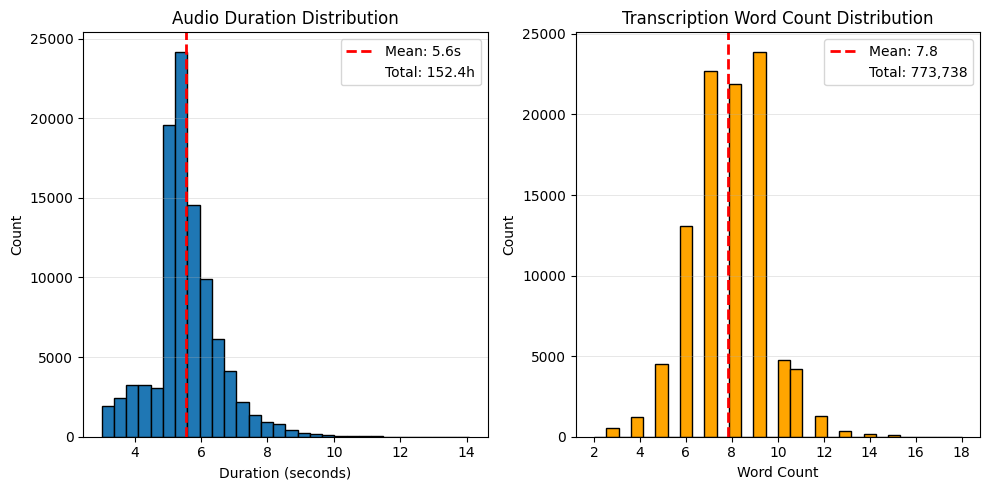

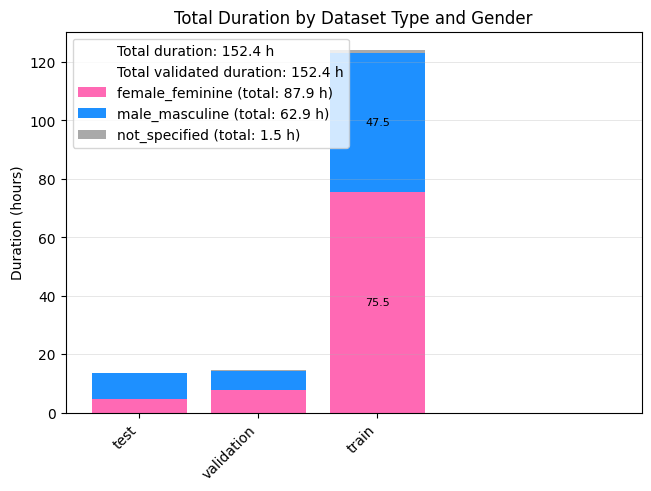

type        accent_region                                     
test        Farg'ona                                              25.45
            Toshkent viloyati                                     11.66
            Surxondaryo                                           11.40
            Navoiy                                                11.09
            Jizzax                                                 7.67
            Toshkent shahri                                        7.44
            Namangan                                               6.81
            Andijon                                                6.70
            Buxoro                                                 3.70
            Samarqand                                              3.20
            Qashqadaryo                                            1.89
            Xorazm                                                 1.39
            Qoraqalpog'iston                                       1.10
 

In [23]:
from scripts.dataset_plotting import plot_distribution_graphs, plot_dataset_type_gender_distribution

plot_distribution_graphs(sampled_df)
plot_dataset_type_gender_distribution(sampled_df)

# Accent region distribution by type
counts = sampled_df.groupby(["type", "accent_region"])["speaker_id"].count()
percentage = (counts / counts.groupby(level=0).sum() * 100).round(2)
percentage = percentage.groupby(level=0, group_keys=False).apply(lambda x: x.sort_values(ascending=False))
print(percentage)

# Age distribution by type
counts = sampled_df.groupby(["type", "age"])["speaker_id"].count()
percentage = (counts / counts.groupby(level=0).sum() * 100).round(2)
percentage = percentage.groupby(level=0, group_keys=False).apply(lambda x: x.sort_values(ascending=False))
print(f"\n{percentage}")

## Part 2

In [63]:
all_data_df = pd.read_csv(ALL_DATA_PATH, index_col="id")
used_paths = set(pd.read_csv(PROCESSED_AUDIO_STATS_PATH)["input_audio_filename"])
unused_data_df = all_data_df[~all_data_df["path"].isin(used_paths)]
print(f"Total available duration: {unused_data_df["duration"].sum() / 3600:.2f} hours")
unused_data_df.describe()

Total available duration: 774.38 hours


,up_votes,down_votes,reported_count,duration,word_count
count,704709.000000,704709.000000,704709.000000,704709.000000,704709.000000
mean,0.703018,0.005306,0.008145,3.955891,6.518899
std,1.704048,0.153216,0.096990,1.035755,1.730276
min,0.000000,0.000000,0.000000,0.216000,1.000000
25%,0.000000,0.000000,0.000000,3.240000,5.000000
50%,0.000000,0.000000,0.000000,3.924000,7.000000
75%,0.000000,0.000000,0.000000,4.536000,8.000000
max,26.000000,19.000000,6.000000,28.152000,19.000000


In [ ]:
sampled_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")

top_100_speakers = sampled_df["speaker_id"].value_counts(ascending=False).head(100)

In [65]:
val_test_speakers_mask = sampled_df["type"].isin(["test", "validation"])
val_test_speakers = set(sampled_df[val_test_speakers_mask]["speaker_id"].unique())

top_100_speakers_mask = unused_data_df["speaker_id"].isin(top_100_speakers)

sampled2_df = unused_data_df[(~unused_data_df["speaker_id"].isin(val_test_speakers)) & (~top_100_speakers_mask)]
print(f"Potential total duration: {sampled2_df["duration"].sum() / 3600:.2f} hours")
sampled2_df

Potential total duration: 584.01 hours


,path,speaker_id,accent_region,up_votes,down_votes,reported_count,age,gender,duration,word_count,sentence
id,,,,,,,,,,,
210496,210496.wav,e3bf850f-ae4b-424c-ab81-bddbab796b19,Namangan,0,0,0,19-29,female_feminine,3.204,4,Djigan Toshkentda konsert beradi.
210499,210499.wav,b2b2ee04-a86b-4ddc-8165-4be7a103fe2f,Jizzax,0,0,0,25-34,male_masculine,2.916,3,"Targ‘ibot qilishdi, tushuntirishdi."
210500,210500.wav,c4093b96-6dd9-4a18-a9ab-b9b716592cd5,Navoiy,4,0,0,< 19,female_feminine,2.052,3,"Asosiysi, yordam berishsin”."
210501,210501.wav,d551d550-6b99-44ff-80ff-06fcbc3c2d84,Farg'ona,5,0,0,19-29,female_feminine,2.736,3,Futbol millionlar o‘yini.
210502,210502.wav,ac7ac54e-6c18-425e-8694-d226e3aa9a5d,Namangan,2,0,0,19-29,female_feminine,2.016,4,"Ayniqsa, yosh bolalar bilan."
...,...,...,...,...,...,...,...,...,...,...,...
526174,526174.wav,f3955702-ad1f-4896-b1f3-de8d2a5d381a,Jizzax,0,0,0,18-24,female_feminine,4.356,6,Toshkent shahrida alkogoldan zaharlanish holat...
526175,526175.wav,8a393ed4-c4c2-4f5f-8ea2-04401704ca56,Xorazm,0,0,0,18-24,female_feminine,2.808,6,"Agar u qo‘l qo‘ymasa, uni otishadi."
526176,526176.wav,d1f293f7-f89c-4455-91cc-140b0d4ac455,Samarqand,0,0,0,18-24,male_masculine,3.132,6,Voqea yuzasidan tergov ishlari olib borilmoqda.


short_recordings: 
count                                    20000
unique                                    3344
top       bd3f11a4-770d-4430-b502-db511508273f
freq                                        26
Name: speaker_id, dtype: object

medium_recordings: 
count                                    43264
unique                                      73
top       10b29e87-bf01-4b16-bead-a044076f849b
freq                                      2000
Name: speaker_id, dtype: object

long_recordings: 
count                                       76
unique                                      20
top       b2ea482e-0e57-428b-9a25-827582772fd7
freq                                        50
Name: speaker_id, dtype: object


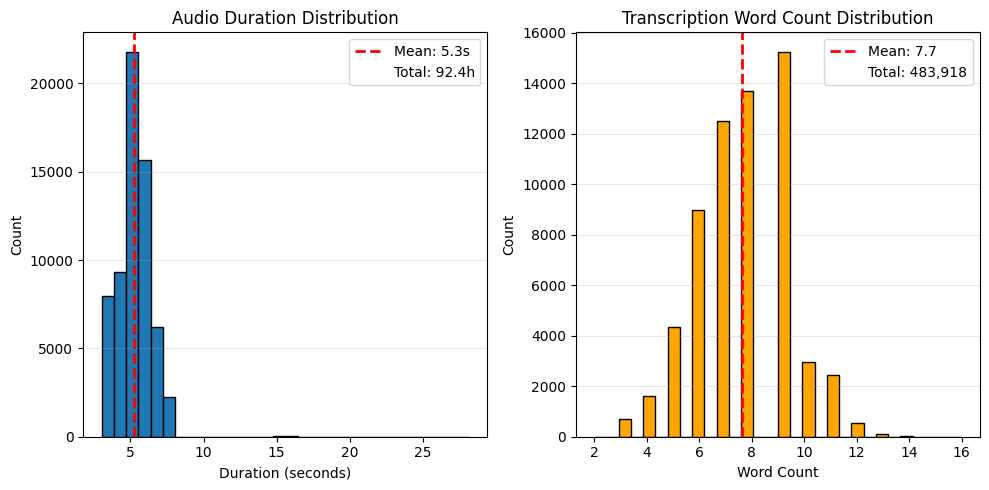

,speaker_id,path,accent_region,up_votes,down_votes,reported_count,age,gender,duration,word_count,sentence,net_votes
id,,,,,,,,,,,,
51,76fe880f-728b-4e9e-9944-750edab0c026,51.wav,NaN,5,0,0,NaN,not_specified,4.860,7,Muhokama qilingan masalalar yuzasidan mutasadd...,5
92,6697ab93-c99e-4fad-86d8-17d4d28e72c7,92.wav,Toshkent shahri,0,3,3,19-29,male_masculine,3.924,3,Hozirgi ishimizdan mamnunman.,-3
97,2291696a-a2cf-4d6d-84aa-7f3ad3190113,97.wav,Jizzax,4,0,0,18-24,male_masculine,3.348,3,“Menga ssenariylar yoqmayapti.,4
98,2291696a-a2cf-4d6d-84aa-7f3ad3190113,98.wav,Jizzax,4,0,0,18-24,male_masculine,3.096,3,Mavzuga oid yangiliklar:,4
99,2291696a-a2cf-4d6d-84aa-7f3ad3190113,99.wav,Jizzax,3,0,0,18-24,male_masculine,3.312,4,Bu qirg‘izlarni kuldirdi .,3
...,...,...,...,...,...,...,...,...,...,...,...,...
864842,17bbf3ac-0132-4bfd-a249-caa0c0041b96,864842.wav,Xorazm,0,0,0,19-29,female_feminine,3.816,6,Tolibon Mozori Sharifda Ahmad Shohni o‘ldirgan\r,0
864847,9c21cf31-0a8a-446c-b76a-3ff5a0fdf0ac,864847.wav,Surxondaryo,0,0,0,19-29,male_masculine,4.140,7,"Jinimdan yomon ko‘raman, shunaqa lattachaynar ...",0
864849,9c21cf31-0a8a-446c-b76a-3ff5a0fdf0ac,864849.wav,Surxondaryo,0,0,0,19-29,male_masculine,3.960,6,"O‘ylamay bo‘ladimi, ketma-ket uchta farzand ke...",0


In [66]:
from scripts.dataset_plotting import plot_distribution_graphs

# Sort by speaker_id for deterministic groupby order
sampled2_df = sampled2_df.sort_values("speaker_id")

short_audios = (sampled2_df["duration"] >= 3) & (sampled2_df["duration"] < 5)
medium_audios = (sampled2_df["duration"] >= 5) & (sampled2_df["duration"] < 8)
long_audios = (sampled2_df["duration"] >= 8) & (sampled2_df["duration"] < 30)

short_samples = (
    sampled2_df[short_audios]
    .groupby("speaker_id")
    .apply(lambda x: x.sample(min(len(x), 30), random_state=SEED),
           include_groups=False)  # Maximum up to 30 recordings per speaker
    .reset_index(level=0)
).sample(20_000, weights="duration", random_state=SEED)
print(f"short_recordings: \n{short_samples["speaker_id"].describe()}")

medium_samples = (
    sampled2_df[medium_audios]
    .groupby("speaker_id")
    .apply(lambda x: x.sample(min(len(x), 2000), random_state=SEED),
           include_groups=False)  # Maximum up to 2000 recordings per speaker
    .reset_index(level=0)
)
print(f"\nmedium_recordings: \n{medium_samples["speaker_id"].describe()}")

long_samples = (
    sampled2_df[long_audios]
    .groupby("speaker_id")
    .apply(lambda x: x.sample(min(len(x), 700), random_state=SEED),
           include_groups=False)  # Maximum up to 700 recordings per speaker
    .reset_index(level=0)
)
print(f"\nlong_recordings: \n{long_samples["speaker_id"].describe()}")

sampled2_df = pd.concat([short_samples, medium_samples, long_samples]).sort_index()

# Remove recordings with net_votes <= -5 (up_votes - down_votes)
sampled2_df.loc[:, "net_votes"] = sampled2_df["up_votes"] - sampled2_df["down_votes"]
majority_down_voted_mask = sampled2_df["net_votes"] <= -5
sampled2_df = sampled2_df[~majority_down_voted_mask]

sampled2_df.to_csv(SAMPLED_DATA2_PATH, index_label="id")

plot_distribution_graphs(sampled2_df)

sampled2_df

In [69]:
import scripts.audio_preprocessing as ap

sampled2_df = pd.read_csv(SAMPLED_DATA2_PATH, index_col="id")

# Extract sampled audios from parquets
sampled_ids = set(sampled2_df.index.tolist())
print(f"Need to extract {len(sampled_ids)} audio files")

# Create directory for extracted audio
os.makedirs(SAMPLED_AUDIO_DIR, exist_ok=True)

parquet_files = glob.glob(f"{DATASET_DIR}/*.parquet")
num_parquets = len(parquet_files)

if num_parquets == 0:
    raise FileNotFoundError(f"No parquet files found. Exiting...")

print(f"Found {num_parquets} parquet files. Started processing...\n")

stats = []
found_count = 0
for parquet_file_path in tqdm(parquet_files, desc="Processing files"):
    if found_count >= len(sampled_ids):
        break

    df_partial = pd.read_parquet(parquet_file_path)

    # Filter to only rows we need
    matching_rows = df_partial[df_partial["id"].isin(sampled_ids)]

    if len(matching_rows) < 1:
        del df_partial
        continue

    # Extract and normalize audios from parquet files
    audio_stats_partial_df = pd.DataFrame()
    for _, row in matching_rows.iterrows():
        audio_bytes = row["path"]["bytes"]

        input_file_name = str(row["id"]) + ".mp3"
        output_file_name = str(row["id"]) + ".wav"
        output_path = os.path.join(SAMPLED_AUDIO_DIR, output_file_name)

        waveform, stat = ap.process_audio_bytes(
            input_file_name,
            audio_bytes,
            save_path=output_path,
            normalize=True,
            target_rms_db=-23.0,
            apply_highpass=True,
            highpass_cutoff=80.0,
            remove_silences=True,
            silence_threshold_db=-45.0,
            min_silence_duration=1.3
        )

        stats.append(stat)
        found_count += 1

    # Explicitly delete the dataframe with heavy audio bytes
    del df_partial
    gc.collect()

processed_audio_stats_df = pd.DataFrame(stats)
processed_audio_stats_df.to_csv(PROCESSED_AUDIO_STATS2_PATH, index=False)

print(f"\nExtracted and normalized {found_count} audio files to {SAMPLED_AUDIO_DIR}")
processed_audio_stats_df

Need to extract 63246 audio files
Found 33 parquet files. Started processing...



Processing files: 100%|██████████| 33/33 [10:59<00:00, 19.98s/it]



Extracted and normalized 63246 audio files to ../datasets/uzbekvoice_dataset/data/sampled_audio


,input_audio_filename,original_rms_db,final_rms_db,original_duration,final_duration,reduced_duration,peak_amplitude,is_clipped
0,210564.mp3,-21.7213,-23.3177,3.204,3.204,0.0,0.6726,False
1,210695.mp3,-19.1259,-23.1385,3.888,3.888,0.0,0.4592,False
2,210714.mp3,-24.5048,-23.4137,3.096,3.096,0.0,0.7812,False
3,210732.mp3,-23.9349,-23.2355,3.024,3.024,0.0,0.7597,False
4,210755.mp3,-16.4298,-23.1273,3.168,3.168,0.0,0.4275,False
...,...,...,...,...,...,...,...,...
63241,525808.mp3,-16.9200,-23.1345,5.148,5.148,0.0,0.4471,False
63242,525859.mp3,-17.0768,-23.1107,3.384,3.384,0.0,0.4537,False
63243,525933.mp3,-18.6711,-23.1781,5.688,5.688,0.0,0.4981,False
63244,526019.mp3,-14.4234,-23.0901,5.148,5.148,0.0,0.3567,False


In [70]:
sampled2_df = pd.read_csv(SAMPLED_DATA2_PATH, index_col="id")
processed_audio_stats_df = pd.read_csv(PROCESSED_AUDIO_STATS2_PATH)

old_total_duration = sampled2_df["duration"].sum() / 3600
old_duration_mean = sampled2_df["duration"].mean()

# --- Replace sampled2_df.duration using processed_audio_stats_df.final_duration ---

# Merge final_duration into the sampled dataframe
sampled2_df = sampled2_df.merge(
    processed_audio_stats_df[["input_audio_filename", "final_duration"]],
    how="left",
    left_on="path",
    right_on="input_audio_filename"
)

# Replace duration only where we have final_duration
sampled2_df["duration"] = (
    sampled2_df["final_duration"].combine_first(sampled2_df["duration"])
)

# Drop helper columns
sampled2_df = sampled2_df.drop(columns=["final_duration"])

# --- Remove suspiciously short and short recordings  ---

# Remove very short audios
mask_short_audio = (processed_audio_stats_df["final_duration"] < 3)
paths_to_remove = processed_audio_stats_df.loc[mask_short_audio, "input_audio_filename"].tolist()

total_reduced_duration = processed_audio_stats_df["reduced_duration"].sum() / 3600

# Remove these rows from processed stats
processed_audio_stats_df = processed_audio_stats_df[
    ~processed_audio_stats_df["input_audio_filename"].isin(paths_to_remove)
]

# Remove these recordings entirely
sampled2_df = sampled2_df[
    ~sampled2_df["path"].isin(paths_to_remove)
]
print(f"{len(paths_to_remove)} recordings are removed from the sample")

# Updated totals
current_total_duration = processed_audio_stats_df["final_duration"].sum() / 3600
current_duration_mean = processed_audio_stats_df["final_duration"].mean()

# Save updated CSVs
processed_audio_stats_df.to_csv(PROCESSED_AUDIO_STATS2_PATH)
sampled2_df.to_csv(SAMPLED_DATA_PATH, index_label="id")

print(
    f"Before audio preprocessing: total duration - {old_total_duration:,.3f} h | mean {old_duration_mean:,.1f} s"
)
print(
    f"After audio preprocessing: total duration - {current_total_duration:,.3f} h "
    f"(reduced {total_reduced_duration * 60:.0f} min) | mean {current_duration_mean:,.1f} s"
)

sampled2_df

56 recordings are removed from the sample
Before audio preprocessing: total duration - 92.394 h | mean 5.3 s
After audio preprocessing: total duration - 91.965 h (reduced 23 min) | mean 5.2 s


,speaker_id,path,accent_region,up_votes,down_votes,reported_count,age,gender,duration,word_count,sentence,net_votes,input_audio_filename
0,76fe880f-728b-4e9e-9944-750edab0c026,51.wav,NaN,5,0,0,NaN,not_specified,4.860,7,Muhokama qilingan masalalar yuzasidan mutasadd...,5,NaN
1,6697ab93-c99e-4fad-86d8-17d4d28e72c7,92.wav,Toshkent shahri,0,3,3,19-29,male_masculine,3.924,3,Hozirgi ishimizdan mamnunman.,-3,NaN
2,2291696a-a2cf-4d6d-84aa-7f3ad3190113,97.wav,Jizzax,4,0,0,18-24,male_masculine,3.348,3,“Menga ssenariylar yoqmayapti.,4,NaN
3,2291696a-a2cf-4d6d-84aa-7f3ad3190113,98.wav,Jizzax,4,0,0,18-24,male_masculine,3.096,3,Mavzuga oid yangiliklar:,4,NaN
4,2291696a-a2cf-4d6d-84aa-7f3ad3190113,99.wav,Jizzax,3,0,0,18-24,male_masculine,3.312,4,Bu qirg‘izlarni kuldirdi .,3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
63241,17bbf3ac-0132-4bfd-a249-caa0c0041b96,864842.wav,Xorazm,0,0,0,19-29,female_feminine,3.816,6,Tolibon Mozori Sharifda Ahmad Shohni o‘ldirgan\r,0,NaN
63242,9c21cf31-0a8a-446c-b76a-3ff5a0fdf0ac,864847.wav,Surxondaryo,0,0,0,19-29,male_masculine,4.140,7,"Jinimdan yomon ko‘raman, shunaqa lattachaynar ...",0,NaN
63243,9c21cf31-0a8a-446c-b76a-3ff5a0fdf0ac,864849.wav,Surxondaryo,0,0,0,19-29,male_masculine,3.960,6,"O‘ylamay bo‘ladimi, ketma-ket uchta farzand ke...",0,NaN
63244,9c21cf31-0a8a-446c-b76a-3ff5a0fdf0ac,864850.wav,Surxondaryo,0,0,0,19-29,male_masculine,15.480,11,"Xususiy mulk daxlsizligini, tadbirkorlikni qo‘...",0,NaN


In [3]:
# Before running set your own PROJECT_ID to .env file (e.g. GOOGLE_CLOUD_PROJECT="your id here")
from pathlib import Path
from scripts import google_transcribe

# Configuration
CHECKPOINT_INTERVAL = 1000  # Save every 1000 audio files
CHECKPOINT_PATH = "transcription_checkpoint.csv"

sampled2_df = pd.read_csv(SAMPLED_DATA2_PATH, index_col="id")

# Prepare audio paths
audio_paths = sampled2_df["path"].apply(
    lambda file_name: os.path.join(SAMPLED_AUDIO_DIR, file_name)
).tolist()

# Check for existing checkpoint
existing_results = []
processed_paths = set()

if os.path.exists(CHECKPOINT_PATH):
    print(f"Found existing checkpoint: {CHECKPOINT_PATH}")
    checkpoint_df = pd.read_csv(CHECKPOINT_PATH)
    existing_results = checkpoint_df.to_dict('records')
    processed_paths = set(checkpoint_df["path"].apply(lambda x: Path(x).name))
    print(f"Resuming from checkpoint with {len(existing_results)} already processed files")

    # Filter out already processed files
    audio_paths = [
        path for path in audio_paths
        if Path(path).name not in processed_paths
    ]
    print(f"Remaining files to process: {len(audio_paths)}")

# Process files in parallel using two regions
print(f"\nProcessing {len(audio_paths)} audio files using 2 regions (eu, us)...")
print("Starting parallel transcription with checkpoint saving...\n")


def save_checkpoint(results_list, is_final=False):
    """Save current results to checkpoint file"""
    df = pd.DataFrame(results_list)
    df.to_csv(CHECKPOINT_PATH, index_label="id")
    status = "FINAL" if is_final else "CHECKPOINT"
    print(f"\n[{status}] Saved {len(results_list)} results to: {CHECKPOINT_PATH}")


try:
    # Start with existing results
    all_results = existing_results.copy()

    # Process remaining files
    if audio_paths:
        results = google_transcribe.transcribe_batch_parallel(
            audio_paths=audio_paths,
            regions=["eu", "us"],
            max_workers=20,
            checkpoint_callback=lambda new_results: save_checkpoint(all_results + new_results),
            checkpoint_interval=CHECKPOINT_INTERVAL
        )
        all_results.extend(results)

    # Save final results
    save_checkpoint(all_results, is_final=True)

except KeyboardInterrupt:
    print("\n\n⚠️  Process interrupted by user!")
    print(f"Partial results saved to checkpoint: {CHECKPOINT_PATH}")
    print("You can resume by running this script again.")
    raise
except Exception as err:
    print(f"\n❌ Critical error during parallel processing: {type(err).__name__}: {err}")
    print(f"Partial results saved to checkpoint: {CHECKPOINT_PATH}")
    raise

# Process final results
predicted_transcriptions = []
failed_count = 0
success_count = 0

for result in all_results:
    transcription_entry = {
        "path": Path(result["path"]).name,
        "predicted_sentence": result["predicted_sentence"],
        "error_message": result["error_message"],
        "error_type": result["error_type"],
    }

    predicted_transcriptions.append(transcription_entry)

    if result["predicted_sentence"] is not None:
        success_count += 1
    else:
        failed_count += 1

# Save final results to the main output file
predicted_transcripts_df = pd.DataFrame(predicted_transcriptions)
predicted_transcripts_df.to_csv(TRANSCRIPTION_RESULTS2_PATH, index_label="id")
print(f"\n✓ Saved final transcription results to: {TRANSCRIPTION_RESULTS2_PATH}")

# Clean up checkpoint file
if os.path.exists(CHECKPOINT_PATH):
    os.remove(CHECKPOINT_PATH)
    print(f"✓ Removed checkpoint file: {CHECKPOINT_PATH}")

print(f"\n{'=' * 60}")
print(f"Transcription Complete!")
print(f"{'=' * 60}")
print(f"✓ Successfully transcribed: {success_count}")
print(f"✗ Failed: {failed_count}")
print(f"Success rate: {success_count / len(sampled2_df) * 100:.2f}%")

predicted_transcripts_df


Processing 63246 audio files using 2 regions (eu, us)...
Starting parallel transcription with checkpoint saving...

Using 2 project(s) across 2 region(s)
Total combinations: 4


Transcribing:   2%|▏         | 1001/63246 [01:45<1:41:49, 10.19file/s]


[CHECKPOINT] Saved 1000 results to: transcription_checkpoint.csv


Transcribing:   3%|▎         | 1999/63246 [03:31<1:54:09,  8.94file/s]


[CHECKPOINT] Saved 2000 results to: transcription_checkpoint.csv


Transcribing:   5%|▍         | 3004/63246 [05:19<1:29:54, 11.17file/s]


[CHECKPOINT] Saved 3000 results to: transcription_checkpoint.csv


Transcribing:   6%|▋         | 4002/63246 [07:14<1:41:16,  9.75file/s]


[CHECKPOINT] Saved 4000 results to: transcription_checkpoint.csv


Transcribing:   8%|▊         | 5000/63246 [09:05<2:16:59,  7.09file/s]


[CHECKPOINT] Saved 5000 results to: transcription_checkpoint.csv


Transcribing:   9%|▉         | 6002/63246 [10:58<1:31:15, 10.46file/s]


[CHECKPOINT] Saved 6000 results to: transcription_checkpoint.csv


Transcribing:  11%|█         | 7003/63246 [12:51<1:37:28,  9.62file/s]


[CHECKPOINT] Saved 7000 results to: transcription_checkpoint.csv


Transcribing:  13%|█▎        | 8003/63246 [14:40<1:37:29,  9.44file/s]


[CHECKPOINT] Saved 8000 results to: transcription_checkpoint.csv


Transcribing:  14%|█▍        | 9004/63246 [16:32<1:34:45,  9.54file/s]


[CHECKPOINT] Saved 9000 results to: transcription_checkpoint.csv


Transcribing:  16%|█▌        | 10001/63246 [18:49<1:40:23,  8.84file/s]


[CHECKPOINT] Saved 10000 results to: transcription_checkpoint.csv


Transcribing:  17%|█▋        | 11002/63246 [20:59<1:24:38, 10.29file/s]


[CHECKPOINT] Saved 11000 results to: transcription_checkpoint.csv


Transcribing:  19%|█▉        | 12000/63246 [23:05<1:51:23,  7.67file/s]


[CHECKPOINT] Saved 12000 results to: transcription_checkpoint.csv


Transcribing:  21%|██        | 13002/63246 [25:10<2:03:34,  6.78file/s]


[CHECKPOINT] Saved 13000 results to: transcription_checkpoint.csv


Transcribing:  22%|██▏       | 14002/63246 [27:18<1:30:04,  9.11file/s]


[CHECKPOINT] Saved 14000 results to: transcription_checkpoint.csv


Transcribing:  24%|██▎       | 14999/63246 [29:18<1:12:56, 11.02file/s]


[CHECKPOINT] Saved 15000 results to: transcription_checkpoint.csv


Transcribing:  25%|██▌       | 16001/63246 [31:21<2:14:30,  5.85file/s]


[CHECKPOINT] Saved 16000 results to: transcription_checkpoint.csv


Transcribing:  27%|██▋       | 17002/63246 [33:07<1:25:08,  9.05file/s]


[CHECKPOINT] Saved 17000 results to: transcription_checkpoint.csv


Transcribing:  28%|██▊       | 18000/63246 [34:52<1:13:35, 10.25file/s]


[CHECKPOINT] Saved 18000 results to: transcription_checkpoint.csv


Transcribing:  30%|███       | 19002/63246 [36:46<1:05:15, 11.30file/s]


[CHECKPOINT] Saved 19000 results to: transcription_checkpoint.csv


Transcribing:  32%|███▏      | 20000/63246 [38:50<1:18:06,  9.23file/s]


[CHECKPOINT] Saved 20000 results to: transcription_checkpoint.csv


Transcribing:  33%|███▎      | 21001/63246 [41:12<1:17:54,  9.04file/s]


[CHECKPOINT] Saved 21000 results to: transcription_checkpoint.csv


Transcribing:  35%|███▍      | 22002/63246 [43:35<1:17:38,  8.85file/s]


[CHECKPOINT] Saved 22000 results to: transcription_checkpoint.csv


Transcribing:  36%|███▋      | 23002/63246 [45:52<1:17:35,  8.64file/s]


[CHECKPOINT] Saved 23000 results to: transcription_checkpoint.csv


Transcribing:  38%|███▊      | 24003/63246 [48:14<57:38, 11.35file/s]  


[CHECKPOINT] Saved 24000 results to: transcription_checkpoint.csv


Transcribing:  40%|███▉      | 25003/63246 [50:35<1:22:11,  7.75file/s]


[CHECKPOINT] Saved 25000 results to: transcription_checkpoint.csv


Transcribing:  41%|████      | 26002/63246 [52:56<1:24:08,  7.38file/s]


[CHECKPOINT] Saved 26000 results to: transcription_checkpoint.csv


Transcribing:  43%|████▎     | 27006/63246 [55:17<1:09:04,  8.74file/s]


[CHECKPOINT] Saved 27000 results to: transcription_checkpoint.csv


Transcribing:  44%|████▍     | 28001/63246 [57:37<56:28, 10.40file/s]  


[CHECKPOINT] Saved 28000 results to: transcription_checkpoint.csv


Transcribing:  46%|████▌     | 29004/63246 [59:58<1:14:58,  7.61file/s]


[CHECKPOINT] Saved 29000 results to: transcription_checkpoint.csv


Transcribing:  47%|████▋     | 30001/63246 [1:02:23<1:31:52,  6.03file/s]


[CHECKPOINT] Saved 30000 results to: transcription_checkpoint.csv


Transcribing:  49%|████▉     | 31000/63246 [1:04:49<1:29:39,  5.99file/s]


[CHECKPOINT] Saved 31000 results to: transcription_checkpoint.csv


Transcribing:  51%|█████     | 32001/63246 [1:07:13<54:46,  9.51file/s]  


[CHECKPOINT] Saved 32000 results to: transcription_checkpoint.csv


Transcribing:  52%|█████▏    | 33002/63246 [1:09:37<1:10:52,  7.11file/s]


[CHECKPOINT] Saved 33000 results to: transcription_checkpoint.csv


Transcribing:  54%|█████▍    | 34005/63246 [1:12:03<48:20, 10.08file/s]  


[CHECKPOINT] Saved 34000 results to: transcription_checkpoint.csv


Transcribing:  55%|█████▌    | 35002/63246 [1:14:27<57:51,  8.14file/s]  


[CHECKPOINT] Saved 35000 results to: transcription_checkpoint.csv


Transcribing:  57%|█████▋    | 36001/63246 [1:16:54<41:03, 11.06file/s]  


[CHECKPOINT] Saved 36000 results to: transcription_checkpoint.csv


Transcribing:  59%|█████▊    | 36999/63246 [1:19:19<55:19,  7.91file/s]  


[CHECKPOINT] Saved 37000 results to: transcription_checkpoint.csv


Transcribing:  60%|██████    | 38004/63246 [1:21:46<1:01:02,  6.89file/s]


[CHECKPOINT] Saved 38000 results to: transcription_checkpoint.csv


Transcribing:  62%|██████▏   | 39000/63246 [1:24:12<56:32,  7.15file/s]  


[CHECKPOINT] Saved 39000 results to: transcription_checkpoint.csv


Transcribing:  63%|██████▎   | 40000/63246 [1:26:35<42:49,  9.05file/s]  


[CHECKPOINT] Saved 40000 results to: transcription_checkpoint.csv


Transcribing:  65%|██████▍   | 41002/63246 [1:28:57<50:14,  7.38file/s]  


[CHECKPOINT] Saved 41000 results to: transcription_checkpoint.csv


Transcribing:  66%|██████▋   | 42001/63246 [1:31:21<53:33,  6.61file/s]  


[CHECKPOINT] Saved 42000 results to: transcription_checkpoint.csv


Transcribing:  68%|██████▊   | 43001/63246 [1:33:40<35:55,  9.39file/s]  


[CHECKPOINT] Saved 43000 results to: transcription_checkpoint.csv


Transcribing:  70%|██████▉   | 44004/63246 [1:35:52<38:16,  8.38file/s]  


[CHECKPOINT] Saved 44000 results to: transcription_checkpoint.csv


Transcribing:  71%|███████   | 45002/63246 [1:38:14<32:47,  9.27file/s]  


[CHECKPOINT] Saved 45000 results to: transcription_checkpoint.csv


Transcribing:  73%|███████▎  | 46002/63246 [1:40:33<29:05,  9.88file/s]  


[CHECKPOINT] Saved 46000 results to: transcription_checkpoint.csv


Transcribing:  74%|███████▍  | 47002/63246 [1:42:50<36:51,  7.35file/s]  


[CHECKPOINT] Saved 47000 results to: transcription_checkpoint.csv


Transcribing:  76%|███████▌  | 48001/63246 [1:45:10<35:00,  7.26file/s]  


[CHECKPOINT] Saved 48000 results to: transcription_checkpoint.csv


Transcribing:  77%|███████▋  | 49001/63246 [1:47:31<32:02,  7.41file/s]  


[CHECKPOINT] Saved 49000 results to: transcription_checkpoint.csv


Transcribing:  79%|███████▉  | 50003/63246 [1:49:54<29:40,  7.44file/s]  


[CHECKPOINT] Saved 50000 results to: transcription_checkpoint.csv


Transcribing:  81%|████████  | 51001/63246 [1:52:21<33:59,  6.00file/s]


[CHECKPOINT] Saved 51000 results to: transcription_checkpoint.csv


Transcribing:  82%|████████▏ | 51999/63246 [1:54:54<13:36, 13.78file/s]  


[CHECKPOINT] Saved 52000 results to: transcription_checkpoint.csv


Transcribing:  84%|████████▍ | 53001/63246 [1:57:22<25:09,  6.79file/s]


[CHECKPOINT] Saved 53000 results to: transcription_checkpoint.csv


Transcribing:  85%|████████▌ | 54003/63246 [1:59:47<15:27,  9.97file/s]


[CHECKPOINT] Saved 54000 results to: transcription_checkpoint.csv


Transcribing:  87%|████████▋ | 55001/63246 [2:02:14<17:51,  7.69file/s]


[CHECKPOINT] Saved 55000 results to: transcription_checkpoint.csv


Transcribing:  89%|████████▊ | 56007/63246 [2:04:38<11:14, 10.73file/s]


[CHECKPOINT] Saved 56000 results to: transcription_checkpoint.csv


Transcribing:  90%|█████████ | 56999/63246 [2:07:09<12:27,  8.36file/s]  


[CHECKPOINT] Saved 57000 results to: transcription_checkpoint.csv


Transcribing:  92%|█████████▏| 58001/63246 [2:09:33<13:09,  6.64file/s]


[CHECKPOINT] Saved 58000 results to: transcription_checkpoint.csv


Transcribing:  93%|█████████▎| 59001/63246 [2:11:56<08:55,  7.92file/s]


[CHECKPOINT] Saved 59000 results to: transcription_checkpoint.csv


Transcribing:  95%|█████████▍| 60003/63246 [2:14:19<06:12,  8.71file/s]


[CHECKPOINT] Saved 60000 results to: transcription_checkpoint.csv


Transcribing:  96%|█████████▋| 61002/63246 [2:16:46<04:44,  7.88file/s]


[CHECKPOINT] Saved 61000 results to: transcription_checkpoint.csv


Transcribing:  98%|█████████▊| 62001/63246 [2:18:51<02:31,  8.19file/s]


[CHECKPOINT] Saved 62000 results to: transcription_checkpoint.csv


Transcribing: 100%|█████████▉| 63005/63246 [2:20:42<00:25,  9.33file/s]


[CHECKPOINT] Saved 63000 results to: transcription_checkpoint.csv


Transcribing: 100%|██████████| 63246/63246 [2:21:11<00:00,  7.47file/s]



[CHECKPOINT] Saved 63246 results to: transcription_checkpoint.csv

[FINAL] Saved 63246 results to: transcription_checkpoint.csv

✓ Saved final transcription results to: ../datasets/uzbekvoice_dataset/data/google_spt_transcriptions2.csv
✓ Removed checkpoint file: transcription_checkpoint.csv

Transcription Complete!
✓ Successfully transcribed: 63245
✗ Failed: 1
Success rate: 100.00%


,path,predicted_sentence,error_message,error_type
0,159.wav,misol keltiradigan bo'lsam,None,None
1,139.wav,Bundan sira afsuslanmaysiz.,None,None
2,97.wav,Menga senariylar yoqmayapti.,None,None
3,203.wav,juftliklar bilan tanishing,None,None
4,114.wav,Buni Kremldagilar kutyapti.,None,None
...,...,...,...,...
63241,864802.wav,Xo'rozning puxi o'ziga og'ir emas.,None,None
63242,864842.wav,Tolibon Mozori Sharifda Ahmad shohni o'ldirgan.,None,None
63243,864849.wav,O'ylamay bo'ladimi? Ketma-ket uchta farzand ke...,None,None
63244,864850.wav,"Xususiy mulk daxlsizligini, tadbirkorlikni qo'...",None,None


In [3]:
sampled2_df = pd.read_csv(SAMPLED_DATA2_PATH, index_col="id")
predicted_transcripts_df = pd.read_csv(TRANSCRIPTION_RESULTS2_PATH, index_col="id")

print(predicted_transcripts_df.info())

# Merge transcription results with original data
sampled2_df = sampled2_df.merge(
    predicted_transcripts_df,
    left_on="path",
    right_on="path",
    how="left"
)

sampled2_df.drop(columns=["error_message", "error_type"], inplace=True, errors="ignore")
sampled2_df.rename(columns={"sentence": "text_original", "predicted_sentence": "text_spt"}, inplace=True)

# Reorder columns
cols = list(sampled2_df.columns)
cols.remove("net_votes")
cols.remove("text_original")
cols.insert(5, "net_votes")
cols.insert(-1, "text_original")
sampled2_df = sampled2_df[cols]

sampled2_df

<class 'pandas.core.frame.DataFrame'>
Index: 63246 entries, 0 to 63245
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   path                63246 non-null  object
 1   predicted_sentence  63121 non-null  object
 2   error_message       1 non-null      object
 3   error_type          1 non-null      object
dtypes: object(4)
memory usage: 2.4+ MB
None


,speaker_id,path,accent_region,up_votes,down_votes,net_votes,reported_count,age,gender,duration,word_count,text_original,text_spt
0,76fe880f-728b-4e9e-9944-750edab0c026,51.wav,NaN,5,0,5,0,NaN,not_specified,4.860,7,Muhokama qilingan masalalar yuzasidan mutasadd...,Muhokama qilingan masalalar yuzasidan mutasadd...
1,6697ab93-c99e-4fad-86d8-17d4d28e72c7,92.wav,Toshkent shahri,0,3,-3,3,19-29,male_masculine,3.924,3,Hozirgi ishimizdan mamnunman.,NaN
2,2291696a-a2cf-4d6d-84aa-7f3ad3190113,97.wav,Jizzax,4,0,4,0,18-24,male_masculine,3.348,3,“Menga ssenariylar yoqmayapti.,Menga senariylar yoqmayapti.
3,2291696a-a2cf-4d6d-84aa-7f3ad3190113,98.wav,Jizzax,4,0,4,0,18-24,male_masculine,3.096,3,Mavzuga oid yangiliklar:,mavzuga oid yangiliklar
4,2291696a-a2cf-4d6d-84aa-7f3ad3190113,99.wav,Jizzax,3,0,3,0,18-24,male_masculine,3.312,4,Bu qirg‘izlarni kuldirdi .,Bu qirg'izlarni kuldirdi.
...,...,...,...,...,...,...,...,...,...,...,...,...,...
63241,17bbf3ac-0132-4bfd-a249-caa0c0041b96,864842.wav,Xorazm,0,0,0,0,19-29,female_feminine,3.816,6,Tolibon Mozori Sharifda Ahmad Shohni o‘ldirgan\r,Tolibon Mozori Sharifda Ahmad shohni o'ldirgan.
63242,9c21cf31-0a8a-446c-b76a-3ff5a0fdf0ac,864847.wav,Surxondaryo,0,0,0,0,19-29,male_masculine,4.140,7,"Jinimdan yomon ko‘raman, shunaqa lattachaynar ...",Jinimdan yomon ko'raman shunaqa lattachaylar y...
63243,9c21cf31-0a8a-446c-b76a-3ff5a0fdf0ac,864849.wav,Surxondaryo,0,0,0,0,19-29,male_masculine,3.960,6,"O‘ylamay bo‘ladimi, ketma-ket uchta farzand ke...",O'ylamay bo'ladimi? Ketma-ket uchta farzand ke...
63244,9c21cf31-0a8a-446c-b76a-3ff5a0fdf0ac,864850.wav,Surxondaryo,0,0,0,0,19-29,male_masculine,15.480,11,"Xususiy mulk daxlsizligini, tadbirkorlikni qo‘...","Xususiy mulk daxlsizligini, tadbirkorlikni qo'..."


In [4]:
# Check if it contains number in digits and number in words (136 000 - bir yuz o'ttiz olti ming)
pattern = r"^(\d+(?: \d{3})*) - [\w| |']+$"
mask = sampled2_df["text_original"].str.contains(pattern, regex=True, na=False)

print(f"Affected number of rows: {len(sampled2_df[mask])}")
print("\nRandom 5 rows that matches the pattern:")
matched_5_rows = sampled2_df[mask][["path", "text_original", "text_spt"]].sample(5)

sampled2_df.loc[mask, "text_original"] = sampled2_df.loc[mask, "text_original"].str.extract(pattern, expand=False)
matched_5_rows

Affected number of rows: 190

Random 5 rows that matches the pattern:


/tmp/ipykernel_12641/2554421636.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = sampled2_df["text_original"].str.contains(pattern, regex=True, na=False)


,path,text_original,text_spt
62942,860493.wav,856 390 - sakkiz yuz ellik olti ming uch yuz t...,856390
62879,859478.wav,30 067 - o'ttiz ming oltmish yetti,30067
62931,860263.wav,72 060 - yetmish ikki ming oltmish,72060
62710,856368.wav,951 015 - to'qqiz yuz ellik bir ming o'n besh,951015
62711,856386.wav,93 029 - to'qson uch ming yigirma to'qqiz,93029


In [5]:
import scripts.similarity_metrics as similarity_metrics

# Apply similarity metrics to each row
metrics = sampled2_df.apply(
    lambda row: similarity_metrics.calculate(
        reference=row["text_original"],
        hypothesis=row["text_spt"],  # Google SPT generated text
    ),
    axis=1
)

# Convert list of dicts → DataFrame
metrics_df = pd.DataFrame(metrics.tolist())

# Merge metric columns back into main DataFrame and save
sampled2_df: pd.DataFrame = pd.concat([sampled2_df, metrics_df], axis=1)

sampled2_df.sort_values("wer", ascending=False)

,speaker_id,path,accent_region,up_votes,down_votes,net_votes,reported_count,age,gender,duration,word_count,text_original,text_spt,ref_normalized,hyp_normalized,wer,cer,sequence_similarity,ref_word_count,hyp_word_count
10658,b2ea482e-0e57-428b-9a25-827582772fd7,138519.wav,Sirdaryo,0,0,0,0,25-34,male_masculine,18.072,6,"Qariya Shenks aytganidek, bu hayot-mamot masal...","Qarish, shishish, shishish, shishish, shishish...",qariya shenks aytganidek bu hayot-mamot masalasi,qarish shishish shishish shishish shishish shi...,422.6667,475.0833,0.0003,6,2536
45174,56ac8e86-b8c9-4879-a342-0eeb94f686fc,599309.wav,Qashqadaryo,0,0,0,0,< 19,female_feminine,5.940,7,Navoiy viloyatida usti yopiq stadion foydalani...,"No, no, no, no, no, no, no, no, no, no, no, no...",navoiy viloyatida usti yopiq stadion foydalani...,no no no no no no no no no no no no no no no n...,197.4286,66.6129,0.0005,7,1382
46829,56ac8e86-b8c9-4879-a342-0eeb94f686fc,639074.wav,Qashqadaryo,0,0,0,0,< 19,female_feminine,6.228,7,"Aniqlanishicha, Shivani kichkinaligidan o‘z so...",ayniqsa shifokorning kichiklanishi o'z vosital...,aniqlanishicha shivani kichkinaligidan o'z soc...,ayniqsa shifokorning kichiklanishi o'z vosital...,178.8571,72.6812,0.0098,7,1253
10653,b2ea482e-0e57-428b-9a25-827582772fd7,138475.wav,Sirdaryo,0,0,0,0,25-34,male_masculine,16.992,7,"O‘sha gapirayotgan odamlar maddoh deydi, pulga...","O'sha gap bilan, keyingi gapim bilan, mana bu ...",o'sha gapirayotgan odamlar maddoh deydi pulga ...,o'sha gap bilan keyingi gapim bilan mana bu ma...,166.2857,115.6769,0.0073,7,1166
27149,82cdab0f-b903-4cca-82aa-11247c5eb17a,394440.wav,Samarqand,0,0,0,0,18-24,male_masculine,5.760,8,Xitoy bahsli orollarga raketa qurilmalarini ma...,Xitoy va Xitoy va Xitoy va Xitoy va Xitoy va X...,xitoy bahsli orollarga raketa qurilmalarini ma...,xitoy va xitoy va xitoy va xitoy va xitoy va x...,165.1250,84.4143,0.0020,8,1322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13569,f3955702-ad1f-4896-b1f3-de8d2a5d381a,168283.wav,Jizzax,0,0,0,0,18-24,female_feminine,5.400,7,"Unga ko‘ra, barcha ayb Tesla elektrokarining e...",Unga ko'ra barcha ayb Tesla elektrokarining eg...,unga ko'ra barcha ayb tesla elektrokarining eg...,unga ko'ra barcha ayb tesla elektrokarining eg...,0.0000,0.0000,1.0000,7,7
13570,10b29e87-bf01-4b16-bead-a044076f849b,168296.wav,Jizzax,0,0,0,0,18-24,male_masculine,5.472,7,Obama qizlari armiyada xizmat o‘tashi mumkinli...,Obama qizlari armiyada xizmat o'tashi mumkinli...,obama qizlari armiyada xizmat o'tashi mumkinli...,obama qizlari armiyada xizmat o'tashi mumkinli...,0.0000,0.0000,1.0000,7,7
13572,b2b2ee04-a86b-4ddc-8165-4be7a103fe2f,168307.wav,Jizzax,0,0,0,0,25-34,male_masculine,6.336,8,Avvalroq Osiyo Chempionlar Ligasi taqvimi e’lo...,Avvalroq Osiyo chempionlar ligasi taqvimi e'lo...,avvalroq osiyo chempionlar ligasi taqvimi e'lo...,avvalroq osiyo chempionlar ligasi taqvimi e'lo...,0.0000,0.0000,1.0000,7,7
35109,2f9b459c-009e-4fb2-b3c9-3a7d1d119179,456020.wav,Jizzax,0,0,0,0,18-24,female_feminine,5.364,8,Raqiblarni musobaqa jadvalida bor-yo‘g‘i bir o...,Raqiblarni musobaqa jadvalida bor-yo'g'i bir o...,raqiblarni musobaqa jadvalida bor-yo'g'i bir o...,raqiblarni musobaqa jadvalida bor-yo'g'i bir o...,0.0000,0.0000,1.0000,8,8


In [6]:
duration_with_high_wer = sampled2_df[sampled2_df["wer"] >= 1.0]["duration"].sum() / 3600
estimated_original_wer = sampled2_df[sampled2_df["wer"] < 1.0]["wer"].mean()
print(
    f"Estimated rough WER: {estimated_original_wer * 100:.2f}% (after removing WER >= 100%, amounting {duration_with_high_wer:.2f} hours)")

Estimated rough WER: 9.11% (after removing WER >= 100%, amounting 0.64 hours)


In [7]:
aligned_mask = sampled2_df["wer"] == 0.0

total_recordings = len(sampled2_df)
not_aligned_duration = sampled2_df[~aligned_mask]["duration"].sum() / 3600

len_aligned_recordings = len(sampled2_df[aligned_mask])
aligned_duration = sampled2_df[aligned_mask]["duration"].sum() / 3600

print(f"Total duration of the sample: {sampled2_df["duration"].sum() / 3600:.2f} hours")
print(
    f"Audio and transcription aligned recordings: {len_aligned_recordings:,} - {aligned_duration:.2f} hours")
print(
    f"Remaining recordings: {total_recordings - len_aligned_recordings:,} - {not_aligned_duration:.2f} hours")

print("\nFinal sample after removing mis-aligned recordings:")

# Remove poor alignment (wer > 0%)
sampled2_df = sampled2_df[aligned_mask]

sampled2_df.to_csv(SAMPLED_DATA2_PATH, index_label="id")
sampled2_df.describe()

Total duration of the sample: 92.39 hours
Audio and transcription aligned recordings: 37,965 - 54.40 hours
Remaining recordings: 25,281 - 37.99 hours

Final sample after removing mis-aligned recordings:


,up_votes,down_votes,net_votes,reported_count,duration,word_count,wer,cer,sequence_similarity,ref_word_count,hyp_word_count
count,37965.000000,37965.000000,37965.000000,37965.000000,37965.000000,37965.000000,37965.0,37965.0,37965.0,37965.000000,37965.000000
mean,0.779797,0.000896,0.778902,0.005189,5.158655,7.568892,0.0,0.0,1.0,7.508521,7.508521
std,1.822872,0.044141,1.823789,0.072578,1.057740,1.732074,0.0,0.0,0.0,1.706036,1.706036
min,0.000000,0.000000,-3.000000,0.000000,3.024000,2.000000,0.0,0.0,1.0,2.000000,2.000000
25%,0.000000,0.000000,0.000000,0.000000,4.392000,6.000000,0.0,0.0,1.0,6.000000,6.000000
50%,0.000000,0.000000,0.000000,0.000000,5.220000,8.000000,0.0,0.0,1.0,8.000000,8.000000
75%,0.000000,0.000000,0.000000,0.000000,5.832000,9.000000,0.0,0.0,1.0,9.000000,9.000000
max,26.000000,3.000000,26.000000,2.000000,26.784000,16.000000,0.0,0.0,1.0,14.000000,14.000000


In [8]:
import glob

sampled1_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")
sampled2_df = pd.read_csv(SAMPLED_DATA2_PATH, index_col="id")

all_audio_paths = set(glob.glob(os.path.join(SAMPLED_AUDIO_DIR, "*.wav")))
audio_paths_to_keep1 = set(
    sampled1_df["path"]
    .apply(lambda file_name: os.path.join(SAMPLED_AUDIO_DIR, file_name))
)
audio_paths_to_keep2 = set(
    sampled2_df["path"]
    .apply(lambda file_name: os.path.join(SAMPLED_AUDIO_DIR, file_name))
)

audio_paths_to_keep = audio_paths_to_keep1.union(audio_paths_to_keep2)
audio_paths_to_remove = all_audio_paths - audio_paths_to_keep

for path in audio_paths_to_remove:
    os.remove(path)

print(f"Removed unnecessary {len(audio_paths_to_remove):,} audio files")

Removed unnecessary 25,281 audio files


In [33]:
sampled1_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")
test_set = sampled1_df[sampled1_df["type"] == "test"]
val_set = sampled1_df[sampled1_df["type"] == "validation"]

# Decrease Test and Validation sets by moving top speakers to train
test_speakers_to_train = set(
    (test_set.groupby("speaker_id")["duration"].sum() / 3600).sort_values(ascending=False).head(7).index)
test_mask = sampled1_df["speaker_id"].isin(test_speakers_to_train)
decreased_test_duration = sampled1_df[test_mask]["duration"].sum() / 3600
print(f"Test set is decreased by {decreased_test_duration:.2f} hours.")

val_speakers_to_train = set(
    (val_set.groupby("speaker_id")["duration"].sum() / 3600).sort_values(ascending=False).head(13).index)
val_mask = sampled1_df["speaker_id"].isin(val_speakers_to_train)
decreased_val_duration = sampled1_df[val_mask]["duration"].sum() / 3600
print(f"Validation set is decreased by {decreased_val_duration:.2f} hours.")

sampled1_df.loc[test_mask, "type"] = "train"
sampled1_df.loc[val_mask, "type"] = "train"
new_train_data = pd.concat([sampled1_df[test_mask], sampled1_df[val_mask]])
new_train_data

Test set is decreased by 7.54 hours.
Validation set is decreased by 8.33 hours.


,speaker_id,path,type,accent_region,up_votes,down_votes,reported_count,age,gender,duration,word_count,text_original,text_spt,ref_normalized,hyp_normalized,wer,cer,sequence_similarity,ref_word_count,hyp_word_count
id,,,,,,,,,,,,,,,,,,,,
117433,963480e6-9d8a-4ab8-85e9-853bacb77db7,647803.wav,train,Namangan,0,0,0,18-24,female_feminine,5.472,7,"Gollar to‘plami: Sancho, Lautaro, Kulibali va ...",gollar to'plami sancho lautaro kulibali va bal...,Gollar to'plami sancho lautaro kulibali va bal...,Gollar to'plami sancho lautaro kulibali va bal...,0.0,0.0,1.0,7,7
146055,d909985a-3ec9-4668-98a5-0b108845c847,801480.wav,train,Toshkent viloyati,0,0,0,18-24,male_masculine,7.416,12,"Savol berishni davom ettirishyapti, tilini ko`...",Savol berishni davom ettirishyapti. Tilini ko'...,Savol berishni davom ettirishyapti. Tilini ko'...,Savol berishni davom ettirishyapti. Tilini ko'...,0.0,0.0,1.0,12,12
149616,304a75fa-6fbc-4b90-af8f-bff9d0babf3d,830435.wav,train,Navoiy,0,0,0,18-24,female_feminine,5.976,11,"chunki, “yolg‘on hayot” ro‘parasida “haq hayot...",Chunki yolg'on hayot ro'parasida haq hayot par...,Chunki yolg'on hayot ro'parasida haq hayot par...,Chunki yolg'on hayot ro'parasida haq hayot par...,0.0,0.0,1.0,11,11
137432,d909985a-3ec9-4668-98a5-0b108845c847,757823.wav,train,Toshkent viloyati,0,0,0,18-24,male_masculine,5.256,8,"Savol: ""Eng yaxshi animatsion rolik"" yo’nalish...",savol eng yaxshi animatsion rolik yo'nalishida...,Savol eng yaxshi animatsion rolik yo'nalishida...,Savol eng yaxshi animatsion rolik yo'nalishida...,0.0,0.0,1.0,8,8
58319,4faeacd7-f209-47f1-80d7-47ff9969c7ce,355421.wav,train,Farg'ona,0,0,0,18-24,male_masculine,5.436,8,"Narxlar bozordagidan nisbatan arzon, eng asosi...",Narxlar bozordagidan nisbatan arzon. Eng asosi...,Narxlar bozordagidan nisbatan arzon. Eng asosi...,Narxlar bozordagidan nisbatan arzon. Eng asosi...,0.0,0.0,1.0,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51286,11d68544-b163-4168-b333-8b273c5ed151,336562.wav,train,Surxondaryo,0,0,0,25-34,male_masculine,8.280,8,"Aksariyat mutaxassislarning fikricha, argentin...","Aksariyat mutaxassislarning fikricha, argentin...","Aksariyat mutaxassislarning fikricha, argentin...","Aksariyat mutaxassislarning fikricha, argentin...",0.0,0.0,1.0,8,8
52435,870a8795-b032-4e12-8cbd-7c8533a9722e,340028.wav,train,Buxoro,0,0,0,18-24,male_masculine,5.220,8,U jangarilar orasida tibbiyot xodimi sifatida ...,U jangarilar orasida tibbiyot xodimi sifatida ...,U jangarilar orasida tibbiyot xodimi sifatida ...,U jangarilar orasida tibbiyot xodimi sifatida ...,0.0,0.0,1.0,8,8
52424,870a8795-b032-4e12-8cbd-7c8533a9722e,339988.wav,train,Buxoro,0,0,0,18-24,male_masculine,5.112,8,Gruziyada rossiyalik va isroillik alpinistlar ...,Gruziyada rossiyalik va isroillik alpinistlar ...,Gruziyada rossiyalik va isroillik alpinistlar ...,Gruziyada rossiyalik va isroillik alpinistlar ...,0.0,0.0,1.0,8,8


In [35]:
sampled2_df = pd.read_csv(SAMPLED_DATA2_PATH, index_col="id")
sampled2_df.fillna({"gender": "Unknown"}, inplace=True)
sampled2_df["type"] = "train"

sampled2_df = pd.concat([
    sampled2_df,
    new_train_data,
    sampled1_df[sampled1_df["type"].isin(["test", "validation"])]
], ignore_index=True)

sampled2_df.to_csv(SAMPLED_DATA2_PATH, index_label="id")

train_speakers = set(sampled2_df.query("type == 'train'")["speaker_id"].unique())
val_speakers = set(sampled2_df.query("type == 'validation'")["speaker_id"].unique())
test_speakers = set(sampled2_df.query("type == 'test'")["speaker_id"].unique())

# Verify no speaker overlap
print(f"\nUnique speakers - Train: {len(train_speakers)}")
print(f"Unique speakers - Validation: {len(val_speakers)}")
print(f"Unique speakers - Test: {len(test_speakers)}")

print(f"\nOverlap Train/Val: {len(train_speakers.intersection(val_speakers))}")
print(f"Overlap Train/Test: {len(train_speakers.intersection(test_speakers))}")
print(f"Overlap Val/Test: {len(val_speakers.intersection(test_speakers))}")

duration_by_type = sampled2_df.groupby("type")["duration"].sum() / 3600
print("\nDuration by type (hours):")
duration_by_type.sort_values(ascending=False)


Unique speakers - Train: 2908
Unique speakers - Validation: 469
Unique speakers - Test: 343

Overlap Train/Val: 0
Overlap Train/Test: 0
Overlap Val/Test: 0

Duration by type (hours):


type
train         70.274833
validation     6.272886
test           6.024537
Name: duration, dtype: float64

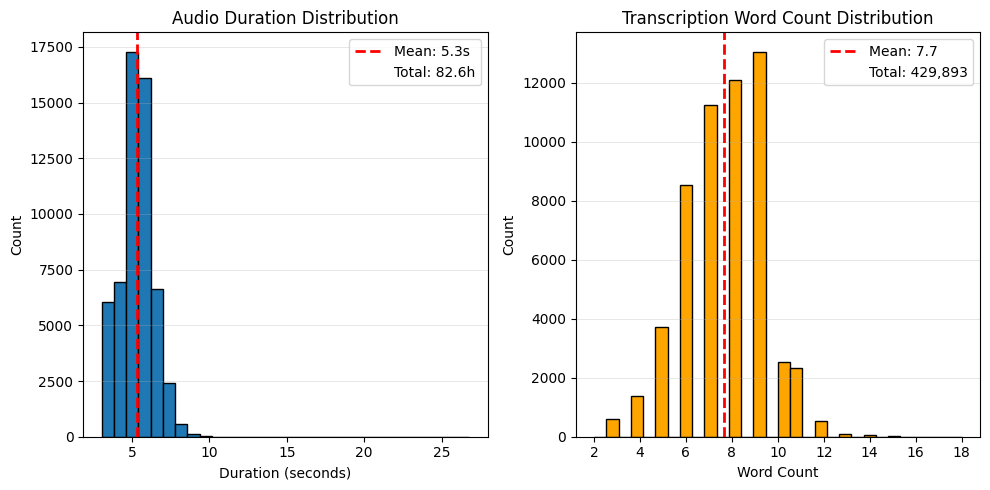

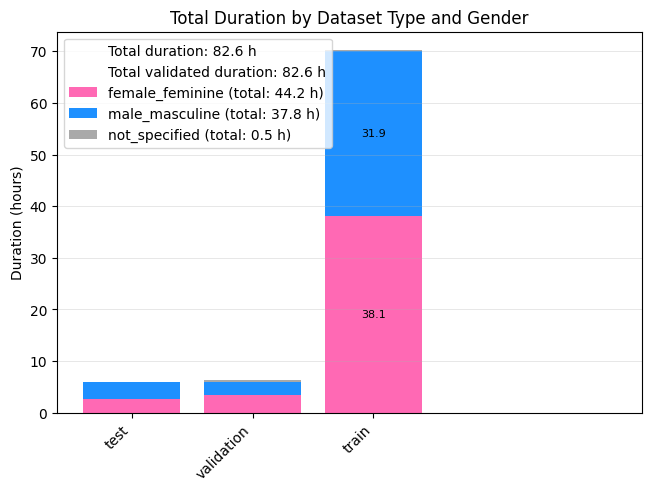

type        accent_region                                     
test        Farg'ona                                              19.64
            Toshkent shahri                                       15.91
            Andijon                                               14.33
            Toshkent viloyati                                     10.61
            Buxoro                                                 7.91
            Samarqand                                              6.84
            Navoiy                                                 5.72
            Jizzax                                                 4.14
            Qashqadaryo                                            4.04
            Surxondaryo                                            3.36
            Xorazm                                                 2.97
            Qoraqalpog'iston                                       2.36
            Namangan                                               1.12
 

In [36]:
from scripts.dataset_plotting import plot_distribution_graphs, plot_dataset_type_gender_distribution

plot_distribution_graphs(sampled2_df)
plot_dataset_type_gender_distribution(sampled2_df)

# Accent region distribution by type
counts = sampled2_df.groupby(["type", "accent_region"])["speaker_id"].count()
percentage = (counts / counts.groupby(level=0).sum() * 100).round(2)
percentage = percentage.groupby(level=0, group_keys=False).apply(lambda x: x.sort_values(ascending=False))
print(percentage)

# Age distribution by type
counts = sampled2_df.groupby(["type", "age"])["speaker_id"].count()
percentage = (counts / counts.groupby(level=0).sum() * 100).round(2)
percentage = percentage.groupby(level=0, group_keys=False).apply(lambda x: x.sort_values(ascending=False))
print(f"\n{percentage}")

In [8]:
sampled1_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")

top_100_speakers = sampled1_df["speaker_id"].value_counts(ascending=False).head(100)
last_10_top_speakers = set(top_100_speakers.tail(10).index)
mask = sampled1_df["speaker_id"].isin(last_10_top_speakers)

total_duration = sampled1_df[mask]["duration"].sum() / 3600
print(f"Total duration among chosen top speakers: {total_duration:.2f} hours")
print(f"Will be used for augmentation")

(sampled1_df[mask].groupby(["speaker_id", "gender"])["duration"].sum() / 3600).sort_values(ascending=False)

Total duration among chosen top speakers: 4.03 hours
Will be used for augmentation


speaker_id                            gender         
1684927e-c0ee-4208-a6ea-ddc556296815  male_masculine     0.450031
6593aaeb-5452-4cab-9971-f246d05ad59f  female_feminine    0.435630
fc3d199c-c321-4539-971d-1b8971009ee1  male_masculine     0.421871
870a8795-b032-4e12-8cbd-7c8533a9722e  male_masculine     0.409460
085114ea-318c-4a90-807f-6804719bce6d  male_masculine     0.404278
ce7fe857-d368-48e7-9dcb-b107aa0d1572  female_feminine    0.393090
dce034dd-4b77-4354-ae25-3aa8e0a6d1a4  female_feminine    0.392189
ce811c72-cf6c-4a49-8572-fd63d3647df5  male_masculine     0.383871
14406f8e-1b54-4e2b-b519-0d3550fe1220  male_masculine     0.372599
0e907318-c231-4fe9-99ac-5543b475e5f0  Unknown            0.369931
Name: duration, dtype: float64

In [9]:
from scripts.audio_augmentation import augment_dataset, AugmentationType

mask = sampled1_df["speaker_id"].isin(last_10_top_speakers)
previous_sample_to_augment = sampled1_df[mask]
previous_sample_to_augment["type"] = "train"

audio_paths = previous_sample_to_augment["path"].apply(
    lambda filename: os.path.join(SAMPLED_AUDIO_DIR, filename)).tolist()

augmentation_types = [
    AugmentationType.SPEED | AugmentationType.NOISE,
    AugmentationType.PITCH | AugmentationType.TIME_MASK,
]

augmentation_df = augment_dataset(
    audio_paths,
    SAMPLED_AUDIO_DIR,
    augmentation_types,
    noise_prob=0.7,
    time_mask_prob=0.7,
    min_speed_rate=0.9,
    max_speed_rate=1.1
)
augmentation_df.to_csv(os.path.join(DATASET_DIR, "augmentation_log.csv"), index_label="id")
augmentation_df

/tmp/ipykernel_23133/186425669.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  previous_sample_to_augment["type"] = "train"
Processing files...: 100%|██████████| 2568/2568 [01:37<00:00, 26.27it/s]


Saved log to ../datasets/uzbekvoice_dataset/data/sampled_audio/augmentation_log.csv


,original_path,augmented_path,original_duration,augmented_duration,speed_applied,speed_rate_applied,pitch_applied,noise_applied,time_mask_applied,augmentation_type
0,849941.wav,849941_augmented_spd_nse.wav,5.076,5.3613,True,0.9468,False,False,False,AugmentationType.SPEED|NOISE
1,849941.wav,849941_augmented_pch_msk.wav,5.076,5.0760,False,1.0000,True,False,True,AugmentationType.PITCH|TIME_MASK
2,864646.wav,864646_augmented_spd_nse.wav,5.976,6.1571,True,0.9706,False,True,False,AugmentationType.SPEED|NOISE
3,864646.wav,864646_augmented_pch_msk.wav,5.976,5.9760,False,1.0000,True,False,True,AugmentationType.PITCH|TIME_MASK
4,864662.wav,864662_augmented_spd_nse.wav,7.272,7.3433,True,0.9903,False,False,False,AugmentationType.SPEED|NOISE
...,...,...,...,...,...,...,...,...,...,...
5131,339988.wav,339988_augmented_pch_msk.wav,5.112,5.1120,False,1.0000,True,False,True,AugmentationType.PITCH|TIME_MASK
5132,339965.wav,339965_augmented_spd_nse.wav,5.436,5.2639,True,1.0327,False,True,False,AugmentationType.SPEED|NOISE
5133,339965.wav,339965_augmented_pch_msk.wav,5.436,5.4360,False,1.0000,True,False,True,AugmentationType.PITCH|TIME_MASK
5134,339779.wav,339779_augmented_spd_nse.wav,5.400,5.1384,True,1.0509,False,True,False,AugmentationType.SPEED|NOISE


In [14]:
augmentation_df = pd.read_csv(os.path.join(DATASET_DIR, "augmentation_log.csv"))
sampled2_df = pd.read_csv(SAMPLED_DATA2_PATH, index_col="id")

previous_sample_to_augment["type"] = "train"
# Fix path and duration
augmented_df = previous_sample_to_augment.merge(
    augmentation_df[["original_path", "augmented_path", "augmented_duration"]],
    left_on="path",
    right_on="original_path",
    how="left"
)

augmented_df.drop(columns=["duration", "original_path", "path"], inplace=True)
augmented_df.rename(columns={"augmented_path": "path", "augmented_duration": "duration"}, inplace=True)

cols = list(augmented_df.columns)
cols.remove("path")
cols.insert(0, "path")
cols.remove("duration")
cols.insert(2, "duration")
augmented_df = augmented_df[cols]

augmented_df = augmented_df[augmented_df["duration"] < 30]

sampled2_df = pd.concat([sampled2_df, augmented_df], ignore_index=True)
sampled2_df = sampled2_df.drop_duplicates(subset=["path", "text_original"], keep='first')

sampled2_df.to_csv(os.path.join(DATASET_DIR, "sampled2.csv"), index_label="id")
sampled2_df

/tmp/ipykernel_23133/3336279362.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  previous_sample_to_augment["type"] = "train"


,speaker_id,path,accent_region,up_votes,down_votes,net_votes,reported_count,age,gender,duration,...,text_original,text_spt,ref_normalized,hyp_normalized,wer,cer,sequence_similarity,ref_word_count,hyp_word_count,type
0,76fe880f-728b-4e9e-9944-750edab0c026,51.wav,NaN,5,0,5.0,0,NaN,not_specified,4.8600,...,Muhokama qilingan masalalar yuzasidan mutasadd...,Muhokama qilingan masalalar yuzasidan mutasadd...,muhokama qilingan masalalar yuzasidan mutasadd...,muhokama qilingan masalalar yuzasidan mutasadd...,0.0,0.0,1.0,7,7,train
1,2291696a-a2cf-4d6d-84aa-7f3ad3190113,98.wav,Jizzax,4,0,4.0,0,18-24,male_masculine,3.0960,...,Mavzuga oid yangiliklar:,mavzuga oid yangiliklar,mavzuga oid yangiliklar,mavzuga oid yangiliklar,0.0,0.0,1.0,3,3,train
2,2291696a-a2cf-4d6d-84aa-7f3ad3190113,99.wav,Jizzax,3,0,3.0,0,18-24,male_masculine,3.3120,...,Bu qirg‘izlarni kuldirdi .,Bu qirg'izlarni kuldirdi.,bu qirg'izlarni kuldirdi,bu qirg'izlarni kuldirdi,0.0,0.0,1.0,3,3,train
3,eecc8201-90e7-4fe9-9875-0d0e15246047,114.wav,Toshkent shahri,5,0,5.0,0,50-59,female_feminine,3.1680,...,Buni Kremldagilar kutyapti.,Buni Kremldagilar kutyapti.,buni kremldagilar kutyapti,buni kremldagilar kutyapti,0.0,0.0,1.0,3,3,train
4,eecc8201-90e7-4fe9-9875-0d0e15246047,123.wav,Toshkent shahri,5,0,5.0,0,50-59,female_feminine,3.0960,...,Haqiqiy fransuzcha ekler.,haqiqiy fransuzcha ekler,haqiqiy fransuzcha ekler,haqiqiy fransuzcha ekler,0.0,0.0,1.0,3,3,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60291,870a8795-b032-4e12-8cbd-7c8533a9722e,339988_augmented_pch_msk.wav,Buxoro,0,0,NaN,0,18-24,male_masculine,5.1120,...,Gruziyada rossiyalik va isroillik alpinistlar ...,Gruziyada rossiyalik va isroillik alpinistlar ...,Gruziyada rossiyalik va isroillik alpinistlar ...,Gruziyada rossiyalik va isroillik alpinistlar ...,0.0,0.0,1.0,8,8,train
60292,870a8795-b032-4e12-8cbd-7c8533a9722e,339965_augmented_spd_nse.wav,Buxoro,0,0,NaN,0,18-24,male_masculine,5.2639,...,O‘zbekistondan Rossiyaga mehnat muhojirlarini ...,O'zbekistondan Rossiyaga mehnat muhojirlarini ...,O'zbekistondan Rossiyaga mehnat muhojirlarini ...,O'zbekistondan Rossiyaga mehnat muhojirlarini ...,0.0,0.0,1.0,8,8,train
60293,870a8795-b032-4e12-8cbd-7c8533a9722e,339965_augmented_pch_msk.wav,Buxoro,0,0,NaN,0,18-24,male_masculine,5.4360,...,O‘zbekistondan Rossiyaga mehnat muhojirlarini ...,O'zbekistondan Rossiyaga mehnat muhojirlarini ...,O'zbekistondan Rossiyaga mehnat muhojirlarini ...,O'zbekistondan Rossiyaga mehnat muhojirlarini ...,0.0,0.0,1.0,8,8,train
60294,870a8795-b032-4e12-8cbd-7c8533a9722e,339779_augmented_spd_nse.wav,Buxoro,0,0,NaN,0,18-24,male_masculine,5.1384,...,O‘zbekiston xokkey federatsiyasi Xalqaro xokke...,O'zbekiston xokkey federatsiyasi Xalqaro xokke...,O'zbekiston xokkey federatsiyasi Xalqaro xokke...,O'zbekiston xokkey federatsiyasi Xalqaro xokke...,0.0,0.0,1.0,8,8,train


In [16]:
augmented_mask = sampled2_df["path"].str.contains("augmented", regex=False)
print(f"Total sampled duration: {sampled2_df["duration"].sum() / 3600:.2f}h")
print(f"Augmented duration: {sampled2_df[augmented_mask]["duration"].sum() / 3600:.2f}h")
(sampled2_df.groupby("type")["duration"].sum() / 3600).sort_values(ascending=False)

Total sampled duration: 88.99h
Augmented duration: 8.08h


type
train         76.695746
validation     6.272886
test           6.024537
Name: duration, dtype: float64

In [17]:
train_speakers = set(sampled2_df.query("type == 'train'")["speaker_id"].unique())
val_speakers = set(sampled2_df.query("type == 'validation'")["speaker_id"].unique())
test_speakers = set(sampled2_df.query("type == 'test'")["speaker_id"].unique())

# Verify no speaker overlap
print(f"\nUnique speakers - Train: {len(train_speakers)}")
print(f"Unique speakers - Validation: {len(val_speakers)}")
print(f"Unique speakers - Test: {len(test_speakers)}")

print(f"\nOverlap Train/Val: {len(train_speakers.intersection(val_speakers))}")
print(f"Overlap Train/Test: {len(train_speakers.intersection(test_speakers))}")
print(f"Overlap Val/Test: {len(val_speakers.intersection(test_speakers))}")


Unique speakers - Train: 2908
Unique speakers - Validation: 469
Unique speakers - Test: 343

Overlap Train/Val: 0
Overlap Train/Test: 0
Overlap Val/Test: 0


In [18]:
import glob

sampled1_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")
sampled2_df = pd.read_csv(SAMPLED_DATA2_PATH, index_col="id")

all_audio_paths = set(glob.glob(os.path.join(SAMPLED_AUDIO_DIR, "*.wav")))
audio_paths_to_keep1 = set(
    sampled1_df["path"]
    .apply(lambda file_name: os.path.join(SAMPLED_AUDIO_DIR, file_name))
)
audio_paths_to_keep2 = set(
    sampled2_df["path"]
    .apply(lambda file_name: os.path.join(SAMPLED_AUDIO_DIR, file_name))
)

audio_paths_to_keep = audio_paths_to_keep1.union(audio_paths_to_keep2)

# Verify all audio files exist
print("Checking audio files...")
missing_files = []
for idx, path in enumerate(audio_paths_to_keep):
    if not os.path.exists(path):
        missing_files.append((idx, path))

if missing_files:
    print(f"⚠ WARNING: {len(missing_files)} audio files not found!")
else:
    print(f"✓ All {len(audio_paths_to_keep)} audio files found")

Checking audio files...
✓ All 141774 audio files found
